# Data 102 Final Project

Jason Chen, Monse Lopez, Ava Taghizadeh, & Sandra Zavala

- Research Question 1 (Comparing GLMs and non-parametric methods): Can we predict the chances of contracting a form of cardiovascular disease(s) given certain demographics of a person [in the United States]?
- Research Question 2 (Causal inference): Do fine air pollutants levels (PM2.5 fine particles) affect the mortality rate of cardiovascular diseases in a particular area [in the United States]?


In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# import geopandas as gpd
# from shapely.geometry import Point
# from shapely import wkt
# import geopandas

# try:
#     from pymc3 import *
#     import pymc3 as pm
# except:
#     ! pip install pymc3
#     from pymc3 import *
#     import pymc3 as pm

# import arviz as az
from pymc3 import glm
# from scipy.stats import poisson, norm, gamma


%matplotlib inline

# Research Question Results

# Data Cleaning

In [6]:
## Reading into UNFILTERED Chronic Disease Indicator dataset. 

us_cdi = pd.read_csv('us_cdi.csv')


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
#all values in dropped col are null -> drop
us_cdi[us_cdi['Response'].notnull()]
us_cdi = us_cdi.drop(['Response','StratificationCategory2','Stratification2','StratificationCategory3','Stratification3','StratificationCategoryID2','StratificationID2','StratificationCategoryID3','StratificationID3','ResponseID'], axis=1)
us_cdi.head()

YearStart  YearEnd LocationAbbr LocationDesc         DataSource   Topic  \
0       2010     2014           AK       Alaska  Death Certificate  Cancer   
1       2010     2014           AK       Alaska  Death Certificate  Cancer   
2       2010     2014           AZ      Arizona  Death Certificate  Cancer   
3       2008     2012           NY     New York  Death Certificate  Cancer   
4       2009     2013           NY     New York  Death Certificate  Cancer   

                                           Question DataValueUnit  \
0  Cancer of the oral cavity and pharynx, mortality           NaN   
1  Cancer of the oral cavity and pharynx, mortality           NaN   
2  Cancer of the oral cavity and pharynx, mortality           NaN   
3  Cancer of the oral cavity and pharynx, mortality           NaN   
4  Cancer of the oral cavity and pharynx, mortality           NaN   

           DataValueType DataValue  ...  HighConfidenceLimit  \
0  Average Annual Number         3  ...                  NaN   
1  Average Annual Number        15  ...                  NaN   
2  Average Annual Number       109  ...                  NaN   
3  Average Annual Number       329  ...                  NaN   
4  Average Annual Number       336  ...                  NaN   

  StratificationCategory1 Stratification1                       GeoLocation  \
0                  Gender          Female   POINT (-147.722059 64.84507996)   
1                 Overall         Overall   POINT (-147.722059 64.84507996)   
2                  Gender            Male  POINT (-111.7638113 34.86597028)   
3                  Gender            Male  POINT (-75.54397043 42.82700103)   
4                  Gender            Male  POINT (-75.54397043 42.82700103)   

   LocationID TopicID QuestionID DataValueTypeID  StratificationCategoryID1  \
0           2     CAN    CAN10_2      AVGANNNMBR                     GENDER   
1           2     CAN    CAN10_2      AVGANNNMBR                    OVERALL   
2           4     CAN    CAN10_2      AVGANNNMBR                     GENDER   
3          36     CAN    CAN10_2      AVGANNNMBR                     GENDER   
4          36     CAN    CAN10_2      AVGANNNMBR                     GENDER   

  StratificationID1  
0              GENF  
1               OVR  
2              GENM  
3              GENM  
4              GENM  

[5 rows x 24 columns]

In [8]:
df = us_cdi.loc[us_cdi['Topic'] == 'Cardiovascular Disease']

In [9]:
df = df.loc[(df['Question'] == 'Mortality from total cardiovascular diseases') & (df['Topic'] == 'Cardiovascular Disease')]
df = df.loc[(df['DataValueType'] == 'Age-adjusted Rate')]
df = df.loc[(df['StratificationCategory1'] == 'Race/Ethnicity')]
df = df[df['DataValue'].notna()]
df = df.drop(['YearEnd', 'LocationAbbr', 'DataSource', 'Topic', 'Question', 'DataValueUnit', 'DataValueAlt', 'DataValueType', 'DataValueFootnoteSymbol','DatavalueFootnote', 'LowConfidenceLimit', 'HighConfidenceLimit', 'StratificationCategory1','GeoLocation', 'LocationID', 'TopicID', 'QuestionID', 'DataValueTypeID', 'StratificationCategoryID1','StratificationID1'], axis=1)
# df.head()

In [10]:
#One-Hot Encode Race
d = pd.get_dummies(df['Stratification1'], prefix='Stratification')
df2 = pd.concat([df, d], axis=1)
df2.head()

YearStart LocationDesc DataValue                   Stratification1  \
165005       2012       Alaska     126.2         Asian or Pacific Islander   
165075       2011      Arizona     174.7  American Indian or Alaska Native   
165199       2013      Arizona     262.2               Black, non-Hispanic   
165264       2014      Arizona     185.2               White, non-Hispanic   
165314       2010      Alabama     297.3               White, non-Hispanic   

        Stratification_American Indian or Alaska Native  \
165005                                                0   
165075                                                1   
165199                                                0   
165264                                                0   
165314                                                0   

        Stratification_Asian or Pacific Islander  \
165005                                         1   
165075                                         0   
165199                                         0   
165264                                         0   
165314                                         0   

        Stratification_Black, non-Hispanic  Stratification_Hispanic  \
165005                                   0                        0   
165075                                   0                        0   
165199                                   1                        0   
165264                                   0                        0   
165314                                   0                        0   

        Stratification_White, non-Hispanic  
165005                                   0  
165075                                   0  
165199                                   0  
165264                                   1  
165314                                   1

##### Diabetes

In [11]:
#Diagnosed Diabetes; Total; Adults Aged 18+ Years; Age-Adjusted Percentage; U.S. States; 2008-2018
diabetes = pd.read_csv('DiabetesAtlasData.csv')
diabetes_drop = diabetes.iloc[:-3, :]
diabetes_drop.isna().sum()
diabetes_drop.head()

State  2010  2011  2012  2013  2014  2015  2016  2017  2018
0  Median of States   8.3   9.0   9.0   9.0   9.2   9.1   9.5   9.4   9.8
1           Alabama  11.3  10.9  11.1  12.7  11.8  12.0  13.2  12.5  12.7
2            Alaska   6.0   8.6   7.2   7.3   7.6   7.8   7.7   7.7   8.7
3           Arizona   7.5   9.0  10.1   9.8   9.1   9.1   9.7   9.4   9.6
4          Arkansas   8.9  10.3  10.3  10.5  11.5  11.2  12.1  10.8  12.4

In [12]:
## Insert Diabetes DF
diabetes_copy = diabetes_drop.copy() ## Copy diabetes rates without US Territories
diabetes_copy['State'] = diabetes_drop['State']

df2_diabetes = df2.copy() ## Copy Original DF (with race labels updated)
df2_diabetes['Diabetes Rate'] = np.nan ## Insert Empty Column for Diabetes


def diabetes_match(row):
    correct_date = row['YearStart']
    correct_state = row['LocationDesc']
    return diabetes_copy[diabetes_copy['State'].str.contains(correct_state)][str(correct_date)].values[0]

df2_diabetes['Diabetes Rate'] = df2_diabetes.apply(lambda row: diabetes_match(row), axis = 1)
df2_diabetes.head()

YearStart LocationDesc DataValue                   Stratification1  \
165005       2012       Alaska     126.2         Asian or Pacific Islander   
165075       2011      Arizona     174.7  American Indian or Alaska Native   
165199       2013      Arizona     262.2               Black, non-Hispanic   
165264       2014      Arizona     185.2               White, non-Hispanic   
165314       2010      Alabama     297.3               White, non-Hispanic   

        Stratification_American Indian or Alaska Native  \
165005                                                0   
165075                                                1   
165199                                                0   
165264                                                0   
165314                                                0   

        Stratification_Asian or Pacific Islander  \
165005                                         1   
165075                                         0   
165199                                         0   
165264                                         0   
165314                                         0   

        Stratification_Black, non-Hispanic  Stratification_Hispanic  \
165005                                   0                        0   
165075                                   0                        0   
165199                                   1                        0   
165264                                   0                        0   
165314                                   0                        0   

        Stratification_White, non-Hispanic  Diabetes Rate  
165005                                   0            7.2  
165075                                   0            9.0  
165199                                   0            9.8  
165264                                   1            9.1  
165314                                   1           11.3

##### Tobacco

In [13]:
tobacco = pd.read_csv('The_Tax_Burden_on_Tobacco__1970-2019.csv',  usecols=[ 1, 2, 5, 6, 7])
tobacco = tobacco[tobacco["SubMeasureDesc"] == "Cigarette Consumption (Pack Sales Per Capita)"]
yearly_consumption = tobacco.groupby('Year')['Data_Value'].sum()
yearly_consumption = yearly_consumption.reset_index(name = "Year Sum")
combine = tobacco.merge(yearly_consumption, how='left', on='Year')
tobacco_consumption = combine 
tobacco_consumption['Tobacco Consumption Based on US Total'] = (tobacco_consumption['Data_Value'] / tobacco_consumption['Year Sum']) 
tobacco_consumption = tobacco_consumption.sort_values(['Year', 'LocationDesc'], ascending = True)
tobacco_consumption = tobacco_consumption.drop(columns =['Year Sum', 'Data_Value', 'SubMeasureDesc', 'MeasureDesc' ])
tobacco_consumption = tobacco_consumption.pivot(index='LocationDesc', columns='Year', values='Tobacco Consumption Based on US Total').reset_index()
tobacco_consumption = tobacco_consumption.rename(columns={'LocationDesc':'State'})

tobacco_consumption = tobacco_consumption[['State', 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]]
tobacco_consumption.iloc[:,[1,2,3,4,5,6,7,8,9]] = tobacco_consumption.iloc[:,[1,2,3,4,5,6,7,8,9]]*100
tobacco_consumption.head()

Year       State      2010      2011      2012      2013      2014      2015  \
0        Alabama  2.583559  2.552810  2.592893  2.588763  2.590260  2.568116   
1         Alaska  1.582656  1.616033  1.589690  1.562876  1.561713  1.514639   
2        Arizona  0.896116  1.011420  0.964618  0.977799  0.965575  0.973092   
3       Arkansas  2.283650  2.280361  2.334375  2.304240  2.283795  2.284651   
4     California  0.950316  0.970366  0.972335  0.957762  0.952981  0.943476   

Year      2016      2017      2018  
0     2.611681  2.613468  2.608737  
1     1.547019  1.479915  1.483213  
2     1.003824  1.012100  1.039680  
3     2.355293  2.357069  2.394124  
4     0.956023  0.922136  0.791683

In [14]:
## Insert Tobacco into DF

tobacco_copy = tobacco_consumption.copy() ## Copy tobacco consump. rate
tobacco_copy['State'] = tobacco_consumption['State']

df3_tobacco = df2_diabetes.copy() ## Copy DF with added diabetes from before
df3_tobacco['Tobacco Consumption Rate'] = np.nan #Insert empty vals into col

def tobacco_match(row):
    correct_date = row['YearStart']
    correct_state = row['LocationDesc']
    return tobacco_copy[tobacco_copy['State'].str.contains(correct_state)][(correct_date)].values[0]

df3_tobacco['Tobacco Consumption Rate'] = df3_tobacco.apply(lambda row: tobacco_match(row), axis = 1)
df3_tobacco.head()

YearStart LocationDesc DataValue                   Stratification1  \
165005       2012       Alaska     126.2         Asian or Pacific Islander   
165075       2011      Arizona     174.7  American Indian or Alaska Native   
165199       2013      Arizona     262.2               Black, non-Hispanic   
165264       2014      Arizona     185.2               White, non-Hispanic   
165314       2010      Alabama     297.3               White, non-Hispanic   

        Stratification_American Indian or Alaska Native  \
165005                                                0   
165075                                                1   
165199                                                0   
165264                                                0   
165314                                                0   

        Stratification_Asian or Pacific Islander  \
165005                                         1   
165075                                         0   
165199                                         0   
165264                                         0   
165314                                         0   

        Stratification_Black, non-Hispanic  Stratification_Hispanic  \
165005                                   0                        0   
165075                                   0                        0   
165199                                   1                        0   
165264                                   0                        0   
165314                                   0                        0   

        Stratification_White, non-Hispanic  Diabetes Rate  \
165005                                   0            7.2   
165075                                   0            9.0   
165199                                   0            9.8   
165264                                   1            9.1   
165314                                   1           11.3   

        Tobacco Consumption Rate  
165005                  1.589690  
165075                  1.011420  
165199                  0.977799  
165264                  0.965575  
165314                  2.583559

##### Obesity 

In [15]:
#obesity rate by state 2011-2020
import pandas as pd

obesity = pd.read_csv('ExportCSV.csv')
obesity_clean = obesity[['YearStart','LocationDesc','Data_Value']]#,'Low_Confidence_Limit','High_Confidence_Limit']]
obesity_clean = obesity_clean.rename(columns={'Data_Value':'Obesity_Rate'})#,'Low_Confidence_Limit':'Obesity_Low_Conf_Limit','High_Confidence_Limit':'Obesity_High_Conf_Limit'})

obesity_clean2 = obesity_clean.copy()
# obesity_clean3 = obesity_clean2.copy()

obesity_clean2 = obesity_clean2.pivot(index='LocationDesc',columns = 'YearStart', values = 'Obesity_Rate').reset_index()
obesity_clean2 = obesity_clean2.rename(columns={'LocationDesc':'State'})

obesity_clean2 = obesity_clean2[['State', 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]]

obesity_clean2.head()


YearStart       State  2011  2012  2013  2014  2015  2016  2017  2018
0             Alabama    32    33  32.4  33.5  35.6  35.7  36.3  36.2
1              Alaska  27.4  25.7  28.4  29.7  29.8  31.4  34.2  29.5
2             Arizona  25.1    26  26.8  28.9  28.4    29  29.5  29.5
3            Arkansas  30.9  34.5  34.6  35.9  34.5  35.7    35  37.1
4          California  23.8    25  24.1  24.7  24.2    25  25.1  25.8

In [16]:
#2010 predictions:
df_obesity = obesity_clean2.copy()

df_obesity[2018] = pd.to_numeric(df_obesity[2018], errors = 'coerce')
df_obesity[2017] = pd.to_numeric(df_obesity[2017], errors = 'coerce')
df_obesity[2016] = pd.to_numeric(df_obesity[2016], errors = 'coerce')
df_obesity[2015] = pd.to_numeric(df_obesity[2015], errors = 'coerce')
df_obesity[2014] = pd.to_numeric(df_obesity[2014], errors = 'coerce')
df_obesity[2013] = pd.to_numeric(df_obesity[2013], errors = 'coerce')
df_obesity[2012] = pd.to_numeric(df_obesity[2012], errors = 'coerce')
df_obesity[2011] = pd.to_numeric(df_obesity[2011], errors = 'coerce')


df_obesity[2011].fillna((df_obesity[2011].mean()), inplace=True)
df_obesity[2012].fillna((df_obesity[2012].mean()), inplace=True)
df_obesity[2013].fillna((df_obesity[2013].mean()), inplace=True)
df_obesity[2014].fillna((df_obesity[2014].mean()), inplace=True)
df_obesity[2015].fillna((df_obesity[2015].mean()), inplace=True)
df_obesity[2016].fillna((df_obesity[2016].mean()), inplace=True)
df_obesity[2017].fillna((df_obesity[2017].mean()), inplace=True)
df_obesity[2018].fillna((df_obesity[2018].mean()), inplace=True)


df_obesity[2010] = (1 -((df_obesity[2018] - df_obesity[2011]) / df_obesity[2011]) / 7) * df_obesity[2011]
df_obesity.isna().sum()

YearStart
State    0
2011     0
2012     0
2013     0
2014     0
2015     0
2016     0
2017     0
2018     0
2010     0
dtype: int64

In [17]:
# Insert Obesity into DF
df4_obesity = df3_tobacco.copy() ## Copy

def obesity_match(row):
    correct_date = row['YearStart']
    correct_state = row['LocationDesc']
    return (df_obesity[df_obesity['State'].str.contains(correct_state)][correct_date].values[0])

df4_obesity['Obesity Rate'] = df4_obesity.apply(lambda row: obesity_match(row), axis = 1)
df4_obesity.head()

YearStart LocationDesc DataValue                   Stratification1  \
165005       2012       Alaska     126.2         Asian or Pacific Islander   
165075       2011      Arizona     174.7  American Indian or Alaska Native   
165199       2013      Arizona     262.2               Black, non-Hispanic   
165264       2014      Arizona     185.2               White, non-Hispanic   
165314       2010      Alabama     297.3               White, non-Hispanic   

        Stratification_American Indian or Alaska Native  \
165005                                                0   
165075                                                1   
165199                                                0   
165264                                                0   
165314                                                0   

        Stratification_Asian or Pacific Islander  \
165005                                         1   
165075                                         0   
165199                                         0   
165264                                         0   
165314                                         0   

        Stratification_Black, non-Hispanic  Stratification_Hispanic  \
165005                                   0                        0   
165075                                   0                        0   
165199                                   1                        0   
165264                                   0                        0   
165314                                   0                        0   

        Stratification_White, non-Hispanic  Diabetes Rate  \
165005                                   0            7.2   
165075                                   0            9.0   
165199                                   0            9.8   
165264                                   1            9.1   
165314                                   1           11.3   

        Tobacco Consumption Rate  Obesity Rate  
165005                  1.589690          25.7  
165075                  1.011420          25.1  
165199                  0.977799          26.8  
165264                  0.965575          28.9  
165314                  2.583559          31.4

##### Air Quality

In [18]:
#Cleaning Air Quality Data for Q1
daily10 = pd.read_csv('daily_88101_2010.csv')
daily11 = pd.read_csv('daily_88101_2011.csv')
daily12 = pd.read_csv('daily_88101_2012.csv')
daily13 = pd.read_csv('daily_88101_2013.csv')
daily14 = pd.read_csv('daily_88101_2014.csv')
daily15 = pd.read_csv('daily_88101_2015.csv')
daily16 = pd.read_csv('daily_88101_2016.csv')
daily17 = pd.read_csv('daily_88101_2017.csv')
daily18 = pd.read_csv('daily_88101_2018.csv')
daily18['Sample Duration'].value_counts()


1 HOUR           208156
24-HR BLK AVG    203616
24 HOUR           90806
Name: Sample Duration, dtype: int64

##### PM2.5 

In [19]:
#Cleaning pm2.5 data

#daily18[daily18['Sample Duration'] == '24 HOUR']
import datetime

def get_year_average(df):
#State Name, POC, Parameter Name, Sample Duration, Pollutant Standard, Date Local , Arithmetic Mean, AQI
    df = df[df['Sample Duration'] == '24-HR BLK AVG']
    df = df[['State Name', 'Parameter Name', 'Sample Duration', 'Pollutant Standard', 'Date Local' , 'Arithmetic Mean', 'AQI']]
    df['Year'] = pd.DatetimeIndex(df['Date Local']).year
    df = df.groupby('State Name').mean()
    return df

annual18 = get_year_average(daily18)
annual17 = get_year_average(daily17)
annual16 = get_year_average(daily16)
annual15 = get_year_average(daily15)
annual14 = get_year_average(daily14)
annual13 = get_year_average(daily13)
annual12 = get_year_average(daily12)
annual11 = get_year_average(daily11)
annual10 = get_year_average(daily10)

In [21]:
def pm_match(row):
    correct_date = row['YearStart']
    correct_state = row['LocationDesc']
    if correct_date == 2018:
        if correct_state in annual18.index:
            return (annual18[annual18.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return annual18['Arithmetic Mean'].mean()
    if correct_date == 2017:
        if correct_state in annual17.index:
            return (annual17[annual17.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return annual17['Arithmetic Mean'].mean()
    if correct_date == 2016:
        if correct_state in annual16.index:
            return (annual16[annual16.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return annual16['Arithmetic Mean'].mean()
    if correct_date == 2015:
        if correct_state in annual15.index:
            return (annual15[annual15.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return annual15['Arithmetic Mean'].mean()
    if correct_date == 2014:
        if correct_state in annual14.index:
            return (annual14[annual14.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return annual14['Arithmetic Mean'].mean()
    if correct_date == 2013:
        if correct_state in annual13.index:
            return (annual13[annual13.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return annual13['Arithmetic Mean'].mean()
    if correct_date == 2012:
        if correct_state in annual12.index:
            return (annual12[annual12.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return annual12['Arithmetic Mean'].mean()
    if correct_date == 2011:
        if correct_state in annual11.index:
            return (annual11[annual11.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return annual11['Arithmetic Mean'].mean()
    if correct_date == 2010:
        if correct_state in annual10.index:
            return (annual10[annual10.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return annual10['Arithmetic Mean'].mean()


    

df4_obesity['PM2.5 Level - Annual Mean'] = df4_obesity.apply(lambda row: pm_match(row), axis = 1)
df4_obesity.head()

YearStart LocationDesc DataValue                   Stratification1  \
165005       2012       Alaska     126.2         Asian or Pacific Islander   
165075       2011      Arizona     174.7  American Indian or Alaska Native   
165199       2013      Arizona     262.2               Black, non-Hispanic   
165264       2014      Arizona     185.2               White, non-Hispanic   
165314       2010      Alabama     297.3               White, non-Hispanic   

        Stratification_American Indian or Alaska Native  \
165005                                                0   
165075                                                1   
165199                                                0   
165264                                                0   
165314                                                0   

        Stratification_Asian or Pacific Islander  \
165005                                         1   
165075                                         0   
165199                                         0   
165264                                         0   
165314                                         0   

        Stratification_Black, non-Hispanic  Stratification_Hispanic  \
165005                                   0                        0   
165075                                   0                        0   
165199                                   1                        0   
165264                                   0                        0   
165314                                   0                        0   

        Stratification_White, non-Hispanic  Diabetes Rate  \
165005                                   0            7.2   
165075                                   0            9.0   
165199                                   0            9.8   
165264                                   1            9.1   
165314                                   1           11.3   

        Tobacco Consumption Rate  Obesity Rate  PM2.5 Level - Annual Mean  
165005                  1.589690          25.7                   5.069902  
165075                  1.011420          25.1                   9.755282  
165199                  0.977799          26.8                   8.135052  
165264                  0.965575          28.9                   7.918001  
165314                  2.583559          31.4                  12.705419

##### Gender 

In [22]:
# Reads and creates data frame from population 
pop_sex = pd.read_csv('pop_sex.csv')
pop_sex.head()

Title: Population Distribution by Sex | KFF  Unnamed: 1    Unnamed: 2  \
0                      Timeframe: 2008 - 2019         NaN           NaN   
1                                    Location  2008__Male  2008__Female   
2                               United States      0.4895        0.5105   
3                                     Wyoming      0.5031        0.4969   
4                                   Wisconsin      0.4948        0.5052   

    Unnamed: 3  Unnamed: 4    Unnamed: 5   Unnamed: 6  Unnamed: 7  \
0          NaN         NaN           NaN          NaN         NaN   
1  2008__Total  2009__Male  2009__Female  2009__Total  2010__Male   
2            1      0.4896        0.5104            1      0.4878   
3            1      0.5102        0.4898            1      0.5024   
4            1      0.4968        0.5032            1      0.4943   

     Unnamed: 8   Unnamed: 9  ... Unnamed: 28   Unnamed: 29  Unnamed: 30  \
0           NaN          NaN  ...         NaN           NaN          NaN   
1  2010__Female  2010__Total  ...  2017__Male  2017__Female  2017__Total   
2        0.5122            1  ...       0.489         0.511            1   
3        0.4976            1  ...      0.5087        0.4913            1   
4        0.5057            1  ...      0.4948        0.5052            1   

  Unnamed: 31   Unnamed: 32  Unnamed: 33 Unnamed: 34   Unnamed: 35  \
0         NaN           NaN          NaN         NaN           NaN   
1  2018__Male  2018__Female  2018__Total  2019__Male  2019__Female   
2      0.4889        0.5111            1     0.48868       0.51132   
3      0.5043        0.4957            1     0.50861        0.4914   
4      0.4948        0.5052            1     0.49323       0.50677   

   Unnamed: 36 Unnamed: 37  
0          NaN         NaN  
1  2019__Total   Footnotes  
2            1           1  
3            1         NaN  
4            1         NaN  

[5 rows x 38 columns]

In [23]:
sex_header = pop_sex.iloc[1]
pop_sex_df = pd.DataFrame(pop_sex.values[1:], columns=sex_header)
pop_sex_df = pop_sex_df.drop(['2008__Male', '2008__Female', '2009__Male', '2009__Female', '2019__Male', '2019__Female', '2019__Total', 'Footnotes'], axis = 1)
pop_sex_df = pop_sex_df.drop(['2008__Total', '2009__Total', '2010__Total', '2011__Total', '2012__Total', '2013__Total', '2014__Total', '2015__Total', '2016__Total', '2017__Total', '2018__Total'], axis = 1)
pop_sex_df = pop_sex_df.sort_values('Location').dropna()
pop_sex_df_male = pop_sex_df[['Location', '2010__Male', '2011__Male', '2012__Male', '2013__Male', '2014__Male', '2015__Male', '2016__Male', '2017__Male', '2018__Male']]
pop_sex_df_male = pop_sex_df_male.rename(columns={'Location': 'State', '2010__Male': 2010, '2011__Male': 2011, '2012__Male':2012, '2013__Male':2013, '2014__Male':2014, '2015__Male':2015, '2016__Male':2016, '2017__Male':2017, '2018__Male':2018})
pop_sex_df_male

pop_sex_df_male[2018] = pd.to_numeric(pop_sex_df_male[2018], errors = 'coerce') * 100
pop_sex_df_male[2017] = pd.to_numeric(pop_sex_df_male[2017], errors = 'coerce') * 100
pop_sex_df_male[2016] = pd.to_numeric(pop_sex_df_male[2016], errors = 'coerce') * 100
pop_sex_df_male[2015] = pd.to_numeric(pop_sex_df_male[2015], errors = 'coerce') * 100
pop_sex_df_male[2014] = pd.to_numeric(pop_sex_df_male[2014], errors = 'coerce') * 100
pop_sex_df_male[2013] = pd.to_numeric(pop_sex_df_male[2013], errors = 'coerce') * 100 
pop_sex_df_male[2012] = pd.to_numeric(pop_sex_df_male[2012], errors = 'coerce') * 100
pop_sex_df_male[2011] = pd.to_numeric(pop_sex_df_male[2011], errors = 'coerce') * 100
pop_sex_df_male[2010] = pd.to_numeric(pop_sex_df_male[2010], errors = 'coerce') * 100

pop_sex_df_male[2010].fillna((pop_sex_df_male[2010].mean()), inplace=True)
pop_sex_df_male[2011].fillna((pop_sex_df_male[2011].mean()), inplace=True)
pop_sex_df_male[2012].fillna((pop_sex_df_male[2012].mean()), inplace=True)
pop_sex_df_male[2013].fillna((pop_sex_df_male[2013].mean()), inplace=True)
pop_sex_df_male[2014].fillna((pop_sex_df_male[2014].mean()), inplace=True)
pop_sex_df_male[2015].fillna((pop_sex_df_male[2015].mean()), inplace=True)
pop_sex_df_male[2016].fillna((pop_sex_df_male[2016].mean()), inplace=True)
pop_sex_df_male[2017].fillna((pop_sex_df_male[2017].mean()), inplace=True)
pop_sex_df_male[2018].fillna((pop_sex_df_male[2018].mean()), inplace=True)

pop_sex_df_male.isna().sum()


1
State    0
2010     0
2011     0
2012     0
2013     0
2014     0
2015     0
2016     0
2017     0
2018     0
dtype: int64

In [24]:
## Insert Sex into DF

sex_copy = pop_sex_df_male.copy() 

df4_sex = df4_obesity.copy() 
df4_sex['Male Sex %'] = np.nan 


def sex_match(row):
    correct_date = row['YearStart']
    correct_state = row['LocationDesc']
    return (sex_copy[sex_copy['State'].str.contains(correct_state)][correct_date].values[0])


df4_sex['Male Sex %'] = df4_sex.apply(lambda row: sex_match(row), axis = 1)
df4_sex.head()



YearStart LocationDesc DataValue                   Stratification1  \
165005       2012       Alaska     126.2         Asian or Pacific Islander   
165075       2011      Arizona     174.7  American Indian or Alaska Native   
165199       2013      Arizona     262.2               Black, non-Hispanic   
165264       2014      Arizona     185.2               White, non-Hispanic   
165314       2010      Alabama     297.3               White, non-Hispanic   

        Stratification_American Indian or Alaska Native  \
165005                                                0   
165075                                                1   
165199                                                0   
165264                                                0   
165314                                                0   

        Stratification_Asian or Pacific Islander  \
165005                                         1   
165075                                         0   
165199                                         0   
165264                                         0   
165314                                         0   

        Stratification_Black, non-Hispanic  Stratification_Hispanic  \
165005                                   0                        0   
165075                                   0                        0   
165199                                   1                        0   
165264                                   0                        0   
165314                                   0                        0   

        Stratification_White, non-Hispanic  Diabetes Rate  \
165005                                   0            7.2   
165075                                   0            9.0   
165199                                   0            9.8   
165264                                   1            9.1   
165314                                   1           11.3   

        Tobacco Consumption Rate  Obesity Rate  PM2.5 Level - Annual Mean  \
165005                  1.589690          25.7                   5.069902   
165075                  1.011420          25.1                   9.755282   
165199                  0.977799          26.8                   8.135052   
165264                  0.965575          28.9                   7.918001   
165314                  2.583559          31.4                  12.705419   

        Male Sex %  
165005       51.58  
165075       49.22  
165199       49.22  
165264       49.01  
165314       48.24

In [25]:
# Table 23 extracted from XLSX file: Medicare Per Enrollee (Dollars per Person) + Cleaning

health23 = pd.read_csv('Table 23 Medicare Per Enrollee.csv')
health23.drop(health23.tail(2).index,inplace=True)
health23 = health23.iloc[: , :-2]


new_header23 = health23.iloc[0] #grab the first row for the header
health23 = health23[1:] #take the data less the header row
health23.columns = new_header23 #set the header row as the df header

health23_yr = health23.drop(['1991', '1992','1993', '1994', '1995',
                            '1996', '1997', '1998', '1999', '2000',
                            '2001', '2002', '2003', '2004', '2005',
                            '2006', '2007', '2008', '2009'], axis = 1)
health23_yr = health23_yr.iloc[:, : -1] #removes avg growth column
health23_yr= health23_yr.rename(columns={'Region/state of residence':'State'})
health23_yr.head()

0          State     2010     2011     2012     2013     2014
1  United States  $10,487  $10,756  $10,771  $10,827  $10,986
2    New England   10,568   10,836   10,851   10,931   11,187
3    Connecticut   11,083   11,390   11,302   11,633   11,964
4          Maine    8,628    8,997    8,913    9,047    9,325
5  Massachusetts   11,396   11,631   11,744   11,656   11,899

In [26]:
#Add Medicare Expenditure as new column to make new df
medicare = health23_yr.copy()
# df4['Medicare Expenditure'] = np.nan
df4_medicare = df4_sex.copy()
df4_medicare['Medicare Expenditure'] = np.nan

medicare = medicare[medicare.columns[1:]].replace('[\$,]', '', regex=True).astype(float)
#estimates for 2015-2018 based on 1.7% growth rate annually in expenditures
medicare['2015'] = medicare['2014'] * 1.017
medicare['2016'] = medicare['2015'] * 1.017
medicare['2017'] = medicare['2016'] * 1.017
medicare['2018'] = medicare['2017'] * 1.017
#just to fix the dataset
medicare['State'] = health23_yr['State']
medicare

#match the year and state and grab the appropriate input
def match(row):
    correct_date = row['YearStart']
    correct_state = row['LocationDesc']
    return (medicare[medicare['State'].str.contains(correct_state)][str(correct_date)].values[0])

#apply function to get final column in medicare expenditure
df4_medicare['Medicare Expenditure'] = df4_medicare.apply(lambda row: match(row), axis=1)
df4_medicare.head()

YearStart LocationDesc DataValue                   Stratification1  \
165005       2012       Alaska     126.2         Asian or Pacific Islander   
165075       2011      Arizona     174.7  American Indian or Alaska Native   
165199       2013      Arizona     262.2               Black, non-Hispanic   
165264       2014      Arizona     185.2               White, non-Hispanic   
165314       2010      Alabama     297.3               White, non-Hispanic   

        Stratification_American Indian or Alaska Native  \
165005                                                0   
165075                                                1   
165199                                                0   
165264                                                0   
165314                                                0   

        Stratification_Asian or Pacific Islander  \
165005                                         1   
165075                                         0   
165199                                         0   
165264                                         0   
165314                                         0   

        Stratification_Black, non-Hispanic  Stratification_Hispanic  \
165005                                   0                        0   
165075                                   0                        0   
165199                                   1                        0   
165264                                   0                        0   
165314                                   0                        0   

        Stratification_White, non-Hispanic  Diabetes Rate  \
165005                                   0            7.2   
165075                                   0            9.0   
165199                                   0            9.8   
165264                                   1            9.1   
165314                                   1           11.3   

        Tobacco Consumption Rate  Obesity Rate  PM2.5 Level - Annual Mean  \
165005                  1.589690          25.7                   5.069902   
165075                  1.011420          25.1                   9.755282   
165199                  0.977799          26.8                   8.135052   
165264                  0.965575          28.9                   7.918001   
165314                  2.583559          31.4                  12.705419   

        Male Sex %  Medicare Expenditure  
165005       51.58                8833.0  
165075       49.22                9961.0  
165199       49.22               10056.0  
165264       49.01               10096.0  
165314       48.24                9818.0

#### Wind

In [27]:
#Cleaning Air Quality Data for Q1
wind10 = pd.read_csv('daily_WIND_2010.csv')
wind11 = pd.read_csv('daily_WIND_2011.csv')
wind12 = pd.read_csv('daily_WIND_2012.csv')
wind13 = pd.read_csv('daily_WIND_2013.csv')
wind14 = pd.read_csv('daily_WIND_2014.csv')
wind15 = pd.read_csv('daily_WIND_2015.csv')
wind16 = pd.read_csv('daily_WIND_2016.csv')
wind17 = pd.read_csv('daily_WIND_2017.csv')
wind18 = pd.read_csv('daily_WIND_2018.csv')
wind18.head()


State Code  County Code  Site Num  Parameter Code  POC  Latitude  \
0           1           53      1000           61103    1   31.0921   
1           1           53      1000           61103    1   31.0921   
2           1           53      1000           61103    1   31.0921   
3           1           53      1000           61103    1   31.0921   
4           1           53      1000           61103    1   31.0921   

   Longitude  Datum          Parameter Name Sample Duration  ...  AQI  \
0   -87.5435  NAD83  Wind Speed - Resultant          1 HOUR  ...  NaN   
1   -87.5435  NAD83  Wind Speed - Resultant          1 HOUR  ...  NaN   
2   -87.5435  NAD83  Wind Speed - Resultant          1 HOUR  ...  NaN   
3   -87.5435  NAD83  Wind Speed - Resultant          1 HOUR  ...  NaN   
4   -87.5435  NAD83  Wind Speed - Resultant          1 HOUR  ...  NaN   

  Method Code                          Method Name Local Site Name  \
0          67  Instrumental - RM Young Model 05103        PCI MET1   
1          67  Instrumental - RM Young Model 05103        PCI MET1   
2          67  Instrumental - RM Young Model 05103        PCI MET1   
3          67  Instrumental - RM Young Model 05103        PCI MET1   
4          67  Instrumental - RM Young Model 05103        PCI MET1   

           Address  State Name  County Name      City Name  CBSA Name  \
0  Jack Springs Rd     Alabama     Escambia  Not in a city        NaN   
1  Jack Springs Rd     Alabama     Escambia  Not in a city        NaN   
2  Jack Springs Rd     Alabama     Escambia  Not in a city        NaN   
3  Jack Springs Rd     Alabama     Escambia  Not in a city        NaN   
4  Jack Springs Rd     Alabama     Escambia  Not in a city        NaN   

   Date of Last Change  
0           2019-06-24  
1           2019-06-24  
2           2019-06-24  
3           2019-06-24  
4           2019-06-24  

[5 rows x 29 columns]

In [28]:
def get_year_average(df):
#State Name, POC, Parameter Name, Sample Duration, Pollutant Standard, Date Local , Arithmetic Mean, AQI
    df = df[['State Name', 'Parameter Name', 'Sample Duration', 'Pollutant Standard', 'Date Local' , 'Arithmetic Mean', 'AQI']]
    df['Year'] = pd.DatetimeIndex(df['Date Local']).year
    df = df.groupby('State Name').mean()
    return df

wind18 = get_year_average(wind18)
wind17 = get_year_average(wind17)
wind16 = get_year_average(wind16)
wind15 = get_year_average(wind15)
wind14 = get_year_average(wind14)
wind13 = get_year_average(wind13)
wind12 = get_year_average(wind12)
wind11 = get_year_average(wind11)
wind10 = get_year_average(wind10)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [29]:
def wind_match(row):
    correct_date = row['YearStart']
    correct_state = row['LocationDesc']
    if correct_date == 2018:
        if correct_state in wind18.index:
            return (wind18[wind18.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return wind18['Arithmetic Mean'].mean()
    if correct_date == 2017:
        if correct_state in wind17.index:
            return (wind17[wind17.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return wind17['Arithmetic Mean'].mean()
    if correct_date == 2016:
        if correct_state in wind16.index:
            return (wind16[wind16.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return wind16['Arithmetic Mean'].mean()
    if correct_date == 2015:
        if correct_state in wind15.index:
            return (wind15[wind15.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return wind15['Arithmetic Mean'].mean()
    if correct_date == 2014:
        if correct_state in wind14.index:
            return (wind14[wind14.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return wind14['Arithmetic Mean'].mean()
    if correct_date == 2013:
        if correct_state in wind13.index:
            return (wind13[wind13.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return wind13['Arithmetic Mean'].mean()
    if correct_date == 2012:
        if correct_state in wind12.index:
            return (wind12[wind12.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return wind12['Arithmetic Mean'].mean()
    if correct_date == 2011:
        if correct_state in wind11.index:
            return (wind11[wind11.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return wind11['Arithmetic Mean'].mean()
    if correct_date == 2010:
        if correct_state in wind10.index:
            return (wind10[wind10.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return wind10['Arithmetic Mean'].mean()


cleaned_data = df4_medicare.copy() 

cleaned_data['Wind Speed - Annual Mean'] = cleaned_data.apply(lambda row: wind_match(row), axis = 1)
cleaned_data.head()
    

YearStart LocationDesc DataValue                   Stratification1  \
165005       2012       Alaska     126.2         Asian or Pacific Islander   
165075       2011      Arizona     174.7  American Indian or Alaska Native   
165199       2013      Arizona     262.2               Black, non-Hispanic   
165264       2014      Arizona     185.2               White, non-Hispanic   
165314       2010      Alabama     297.3               White, non-Hispanic   

        Stratification_American Indian or Alaska Native  \
165005                                                0   
165075                                                1   
165199                                                0   
165264                                                0   
165314                                                0   

        Stratification_Asian or Pacific Islander  \
165005                                         1   
165075                                         0   
165199                                         0   
165264                                         0   
165314                                         0   

        Stratification_Black, non-Hispanic  Stratification_Hispanic  \
165005                                   0                        0   
165075                                   0                        0   
165199                                   1                        0   
165264                                   0                        0   
165314                                   0                        0   

        Stratification_White, non-Hispanic  Diabetes Rate  \
165005                                   0            7.2   
165075                                   0            9.0   
165199                                   0            9.8   
165264                                   1            9.1   
165314                                   1           11.3   

        Tobacco Consumption Rate  Obesity Rate  PM2.5 Level - Annual Mean  \
165005                  1.589690          25.7                   5.069902   
165075                  1.011420          25.1                   9.755282   
165199                  0.977799          26.8                   8.135052   
165264                  0.965575          28.9                   7.918001   
165314                  2.583559          31.4                  12.705419   

        Male Sex %  Medicare Expenditure  Wind Speed - Annual Mean  
165005       51.58                8833.0                 93.701692  
165075       49.22                9961.0                 94.463339  
165199       49.22               10056.0                 91.714444  
165264       49.01               10096.0                 92.628181  
165314       48.24                9818.0                 95.154195

#### NO2

In [33]:
#Cleaning NO2 emisson Data for Q1
no10 = pd.read_csv('daily_NO2_2010.csv')
no11 = pd.read_csv('daily_NO2_2011.csv')
no12 = pd.read_csv('daily_NO2_2012.csv')
no13 = pd.read_csv('daily_NO2_2013.csv')
no14 = pd.read_csv('daily_NO2_2014.csv')
no15 = pd.read_csv('daily_NO2_2015.csv')
no16 = pd.read_csv('daily_NO2_2016.csv')
no17 = pd.read_csv('daily_NO2_2017.csv')
no18 = pd.read_csv('daily_NO2_2018.csv')
no18.head()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


State Code  County Code  Site Num  Parameter Code  POC   Latitude  \
0           1           73        23           42602    1  33.553056   
1           1           73        23           42602    1  33.553056   
2           1           73        23           42602    1  33.553056   
3           1           73        23           42602    1  33.553056   
4           1           73        23           42602    1  33.553056   

   Longitude  Datum          Parameter Name Sample Duration  ... AQI  \
0    -86.815  WGS84  Nitrogen dioxide (NO2)          1 HOUR  ...   3   
1    -86.815  WGS84  Nitrogen dioxide (NO2)          1 HOUR  ...  18   
2    -86.815  WGS84  Nitrogen dioxide (NO2)          1 HOUR  ...  14   
3    -86.815  WGS84  Nitrogen dioxide (NO2)          1 HOUR  ...  15   
4    -86.815  WGS84  Nitrogen dioxide (NO2)          1 HOUR  ...  34   

  Method Code                                        Method Name  \
0         200  Teledyne-API Model 200EUP or T200UP - Photolyt...   
1         200  Teledyne-API Model 200EUP or T200UP - Photolyt...   
2         200  Teledyne-API Model 200EUP or T200UP - Photolyt...   
3         200  Teledyne-API Model 200EUP or T200UP - Photolyt...   
4         200  Teledyne-API Model 200EUP or T200UP - Photolyt...   

    Local Site Name                                Address  State Name  \
0  North Birmingham  NO. B'HAM,SOU R.R., 3009 28TH ST. NO.     Alabama   
1  North Birmingham  NO. B'HAM,SOU R.R., 3009 28TH ST. NO.     Alabama   
2  North Birmingham  NO. B'HAM,SOU R.R., 3009 28TH ST. NO.     Alabama   
3  North Birmingham  NO. B'HAM,SOU R.R., 3009 28TH ST. NO.     Alabama   
4  North Birmingham  NO. B'HAM,SOU R.R., 3009 28TH ST. NO.     Alabama   

   County Name   City Name              CBSA Name  Date of Last Change  
0    Jefferson  Birmingham  Birmingham-Hoover, AL           2021-11-03  
1    Jefferson  Birmingham  Birmingham-Hoover, AL           2021-11-03  
2    Jefferson  Birmingham  Birmingham-Hoover, AL           2021-11-03  
3    Jefferson  Birmingham  Birmingham-Hoover, AL           2021-11-03  
4    Jefferson  Birmingham  Birmingham-Hoover, AL           2021-11-03  

[5 rows x 29 columns]

In [34]:
def get_year_average(df):
#State Name, POC, Parameter Name, Sample Duration, Pollutant Standard, Date Local , Arithmetic Mean, AQI
    df = df[['State Name', 'Parameter Name', 'Sample Duration', 'Pollutant Standard', 'Date Local' , 'Arithmetic Mean', 'AQI']]
    df['Year'] = pd.DatetimeIndex(df['Date Local']).year
    df = df.groupby('State Name').mean()
    return df

no18 = get_year_average(no18)
no17 = get_year_average(no17)
no16 = get_year_average(no16)
no15 = get_year_average(no15)
no14 = get_year_average(no14)
no13 = get_year_average(no13)
no12 = get_year_average(no12)
no11 = get_year_average(no11)
no10 = get_year_average(no10)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [35]:
def no2_match(row):
    correct_date = row['YearStart']
    correct_state = row['LocationDesc']
    if correct_date == 2018:
        if correct_state in no18.index:
            return (no18[no18.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return no18['Arithmetic Mean'].mean()
    if correct_date == 2017:
        if correct_state in no17.index:
            return (no17[no17.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return no17['Arithmetic Mean'].mean()
    if correct_date == 2016:
        if correct_state in no16.index:
            return (no16[no16.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return no16['Arithmetic Mean'].mean()
    if correct_date == 2015:
        if correct_state in no15.index:
            return (no15[no15.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return no15['Arithmetic Mean'].mean()
    if correct_date == 2014:
        if correct_state in no14.index:
            return (no14[no14.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return no14['Arithmetic Mean'].mean()
    if correct_date == 2013:
        if correct_state in no13.index:
            return (no13[no13.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return no13['Arithmetic Mean'].mean()
    if correct_date == 2012:
        if correct_state in no12.index:
            return (no12[no12.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return no12['Arithmetic Mean'].mean()
    if correct_date == 2011:
        if correct_state in no11.index:
            return (no11[no11.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return no11['Arithmetic Mean'].mean()
    if correct_date == 2010:
        if correct_state in no10.index:
            return (no10[no10.index == correct_state]['Arithmetic Mean'].values[0])
        else:
            return no10['Arithmetic Mean'].mean()


cleaned_data = cleaned_data.copy() 

cleaned_data['NO2 - Annual Mean'] = cleaned_data.apply(lambda row: no2_match(row), axis = 1)
cleaned_data.head()

YearStart LocationDesc DataValue                   Stratification1  \
165005       2012       Alaska     126.2         Asian or Pacific Islander   
165075       2011      Arizona     174.7  American Indian or Alaska Native   
165199       2013      Arizona     262.2               Black, non-Hispanic   
165264       2014      Arizona     185.2               White, non-Hispanic   
165314       2010      Alabama     297.3               White, non-Hispanic   

        Stratification_American Indian or Alaska Native  \
165005                                                0   
165075                                                1   
165199                                                0   
165264                                                0   
165314                                                0   

        Stratification_Asian or Pacific Islander  \
165005                                         1   
165075                                         0   
165199                                         0   
165264                                         0   
165314                                         0   

        Stratification_Black, non-Hispanic  Stratification_Hispanic  \
165005                                   0                        0   
165075                                   0                        0   
165199                                   1                        0   
165264                                   0                        0   
165314                                   0                        0   

        Stratification_White, non-Hispanic  Diabetes Rate  \
165005                                   0            7.2   
165075                                   0            9.0   
165199                                   0            9.8   
165264                                   1            9.1   
165314                                   1           11.3   

        Tobacco Consumption Rate  Obesity Rate  PM2.5 Level - Annual Mean  \
165005                  1.589690          25.7                   5.069902   
165075                  1.011420          25.1                   9.755282   
165199                  0.977799          26.8                   8.135052   
165264                  0.965575          28.9                   7.918001   
165314                  2.583559          31.4                  12.705419   

        Male Sex %  Medicare Expenditure  Wind Speed - Annual Mean  \
165005       51.58                8833.0                 93.701692   
165075       49.22                9961.0                 94.463339   
165199       49.22               10056.0                 91.714444   
165264       49.01               10096.0                 92.628181   
165314       48.24                9818.0                 95.154195   

        NO2 - Annual Mean  
165005           8.750745  
165075          16.014585  
165199          15.447360  
165264          15.197195  
165314           8.871013

# EDA

• Visualize at least two quantitative variables and two categorical variables. Your visualizations must be relevant to your research questions! 

Categorical: race, gender quantitative: pm2.5 emission(annual mean), No2 emission rate(annual mean), cardiovascular mortality rate

• Describe any trends you observe, and any relationships you may want to follow up on. 

A trend observed is the how there exists different rates of cardiovascular mortality among different demographics in the U.S. It is important to note that there are other variables that have a relationship to cardiovascular mortality rate which includes, but is not limited to- medicare expenditure within the region/state that a person resides in as well as other health problems that are connected to cardiovascular issues. Thus, obesity and diabetes were additional variables taken into consideration when predicting the chance of contracting a form of cardiovascular disease based on the demographic background of an individual.

• Describe any data cleaning steps you took. How will these decisions impact your model and inferences? 

The cleaning steps taken involved merging six datasets. The initial dataset collected by the CDC that contains cardiovascular mortality rate had a distinct format that the other five datasets had to be cleaned and formatted to. Thus, a custom function was encoded to match and merge the datasets into one clean dataset that has data by state. A decision made when cleaning the data that will impact our model and decisions was taking the annual mean by state for No2 emission, PM2.5 emission, and wind speed data as these datasets were collected on a daily basis yearly. Aggregating smooths out the data and allows for a more accurate analysis.There were also discrepancies in time as datasets had time gaps that needed to be accounted for through estimation. For example, medicare expenditure only has years 2015-2018 available thus an annual growth of 1.7% was accounted for in order to estimate for the time gap from 2010-2014.

• Explain how your visualizations are relevant to your research questions: do they motivate the question you’re asking? Do they suggest a potential answer?  For example, are there any particular groups that have higher frequencies of missing values?  

The two scatterplots mapped below demonstrate how there is a greater correlation between NO2 and PM2.5 than between wind speed and PM 2.5. The scatterplot helped determine which variable would likely be a confounder for PM2.5, which in this case is NO2. NO2 has a positive correlation to PM2.5 while wind speed has a negative correlation to PM2.5. The bar plot below visualizes the different mortality rates of cardiovascular diseases between men and women averaged by year. These difference can point to gender being a solid demographic variable for predicting the chances of a person affected by cardiovascular disease. Furthermore, a second bar plot visualizes the varying mortality rates of cardiovascular disease categorized by race.  There was two groups- Black and indigenous people- that had a higher percent of cardiovascular disease mortality, so it demonstrates that race is a valid demographic feature to use to predict cardiovascular disease.

• Explain how your visualizations should be relevant to your research questions: either by motivating the question, or suggesting a potential answer. You must explain why they are relevant. 

The scatterplots narrow down the number of confounders that are feasible for the release of air pollution -i.e pm2.5. By comparing NO2 and wind speed to PM2.5 through a scatterplot, we can determine the variable that would serve as a better confounder for PM2.5. The varying cardiovascular mortality rates between male and female population in the U.S. demonstrates exists demographic differences that can predict and help determine the chances of an individual being contracted by cardiovascular disease. This outlook can also be applied to the demographic factor race, as there exists different rates of cardiovascular mortality among different races/ethnicities in the U.S.

In [37]:
data_fem = cleaned_data.copy()
data_fem['Female Sex %'] = 100 - data_fem[['Male Sex %']]
data_fem

YearStart LocationDesc DataValue                   Stratification1  \
165005       2012       Alaska     126.2         Asian or Pacific Islander   
165075       2011      Arizona     174.7  American Indian or Alaska Native   
165199       2013      Arizona     262.2               Black, non-Hispanic   
165264       2014      Arizona     185.2               White, non-Hispanic   
165314       2010      Alabama     297.3               White, non-Hispanic   
...           ...          ...       ...                               ...   
192372       2010     Kentucky     102.3                          Hispanic   
192378       2013  Mississippi     204.7  American Indian or Alaska Native   
192381       2016     Arkansas      94.6                          Hispanic   
192394       2018       Hawaii     153.8               Black, non-Hispanic   
192405       2013   New Mexico     103.7         Asian or Pacific Islander   

        Stratification_American Indian or Alaska Native  \
165005                                                0   
165075                                                1   
165199                                                0   
165264                                                0   
165314                                                0   
...                                                 ...   
192372                                                0   
192378                                                1   
192381                                                0   
192394                                                0   
192405                                                0   

        Stratification_Asian or Pacific Islander  \
165005                                         1   
165075                                         0   
165199                                         0   
165264                                         0   
165314                                         0   
...                                          ...   
192372                                         0   
192378                                         0   
192381                                         0   
192394                                         0   
192405                                         1   

        Stratification_Black, non-Hispanic  Stratification_Hispanic  \
165005                                   0                        0   
165075                                   0                        0   
165199                                   1                        0   
165264                                   0                        0   
165314                                   0                        0   
...                                    ...                      ...   
192372                                   0                        1   
192378                                   0                        0   
192381                                   0                        1   
192394                                   1                        0   
192405                                   0                        0   

        Stratification_White, non-Hispanic  Diabetes Rate  \
165005                                   0            7.2   
165075                                   0            9.0   
165199                                   0            9.8   
165264                                   1            9.1   
165314                                   1           11.3   
...                                    ...            ...   
192372                                   0            9.3   
192378                                   0           12.0   
192381                                   0           12.1   
192394                                   0           10.3   
192405                                   0            9.8   

        Tobacco Consumption Rate  Obesity Rate  PM2.5 Level - Annual Mean  \
165005                  1.589690     25.700000                   5.069902 

The two scatterplots mapped below demonstrate how there is a greater correlation between NO2 and PM2.5 than between wind speed and PM 2.5. The scatterplot helped determine which variable would likely be a confounder for PM2.5, which in this case is NO2.

0.15857956712982818


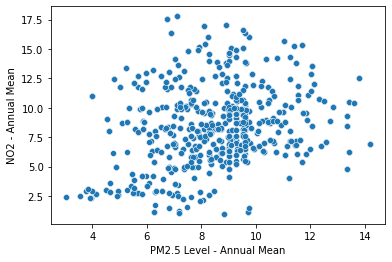

In [38]:
#Testing Corr of NO2 on PM2.5
x2 = sns.scatterplot(x='PM2.5 Level - Annual Mean', y = 'NO2 - Annual Mean', data = cleaned_data)
x2

correlation2 = cleaned_data['NO2 - Annual Mean'].corr(cleaned_data['PM2.5 Level - Annual Mean'])
print(correlation2)

-0.000515691584460854


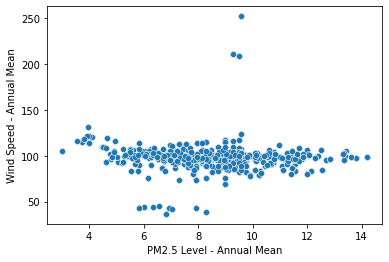

In [39]:
# Testing Corr of Wind Speed on PM2.5
x = sns.scatterplot(x='PM2.5 Level - Annual Mean', y = 'Wind Speed - Annual Mean', data = cleaned_data)
x

correlation = cleaned_data['Wind Speed - Annual Mean'].corr(cleaned_data['PM2.5 Level - Annual Mean'])
print(correlation)

In [40]:
#2010-2018 average of male sex % by state
data_fem2 = data_fem.groupby('LocationDesc')[['Male Sex %', 'Female Sex %']].mean()
data_fem2.reset_index(inplace=True)
data_fem2 = data_fem2.rename(columns = {'index':'LocationDesc'})
data_fem2

LocationDesc  Male Sex %  Female Sex %
0                Alabama   48.076744     51.923256
1                 Alaska   51.193684     48.806316
2                Arizona   49.157778     50.842222
3               Arkansas   48.834054     51.165946
4             California   49.330000     50.670000
5               Colorado   49.801111     50.198889
6            Connecticut   48.542222     51.457778
7               Delaware   48.076875     51.923125
8   District of Columbia   47.132000     52.868000
9                Florida   48.453333     51.546667
10               Georgia   48.208649     51.791351
11                Hawaii   48.998529     51.001471
12                 Idaho   49.826471     50.173529
13              Illinois   48.831905     51.168095
14               Indiana   48.975556     51.024444
15                  Iowa   49.477297     50.522703
16                Kansas   49.317778     50.682222
17              Kentucky   48.838889     51.161111
18             Louisiana   48.250000     51.750000
19                 Maine   48.716364     51.283636
20              Maryland   48.082105     51.917895
21         Massachusetts   48.466053     51.533947
22              Michigan   48.904444     51.095556
23             Minnesota   49.594444     50.405556
24           Mississippi   47.893571     52.106429
25              Missouri   48.717500     51.282500
26               Montana   49.992727     50.007273
27              Nebraska   49.573421     50.426579
28                Nevada   49.898889     50.101111
29         New Hampshire   49.410000     50.590000
30            New Jersey   48.557778     51.442222
31            New Mexico   49.098182     50.901818
32              New York   48.331111     51.668889
33        North Carolina   48.133333     51.866667
34          North Dakota   50.821111     49.178889
35                  Ohio   48.731395     51.268605
36              Oklahoma   48.960000     51.040000
37                Oregon   49.325556     50.674444
38          Pennsylvania   48.635250     51.364750
39          Rhode Island   48.443824     51.556176
40        South Carolina   48.039762     51.960238
41          South Dakota   50.026667     49.973333
42             Tennessee   48.421622     51.578378
43                 Texas   49.153333     50.846667
44                  Utah   50.166667     49.833333
45               Vermont   49.213333     50.786667
46              Virginia   48.385349     51.614651
47            Washington   49.555556     50.444444
48         West Virginia   49.082222     50.917778
49             Wisconsin   49.438889     50.561111
50               Wyoming   50.398182     49.601818

In [41]:
#medicare expenditure by race in the us
race_med_group = data_fem.groupby('Stratification1')[['Medicare Expenditure']].mean()
race_med_group.reset_index(inplace=True)
race_med_group = race_med_group.rename(columns = {'index':'Stratification1'})
race_med_group

Stratification1  Medicare Expenditure
0  American Indian or Alaska Native          10276.671806
1         Asian or Pacific Islander          10583.651304
2               Black, non-Hispanic          10634.810299
3                          Hispanic          10549.585548
4               White, non-Hispanic          10375.442514

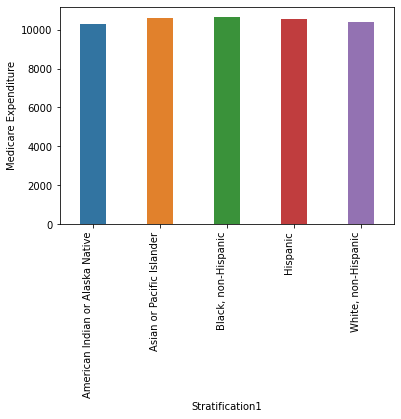

In [42]:
fig, ax = plt.subplots()
race_med_plot = sns.barplot(x="Stratification1", y="Medicare Expenditure", data=race_med_group)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .4)
race_med_plot.set_xticklabels(race_med_plot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

In [43]:
#mortality rate by race in the us after taking average
race_mortality = data_fem
race_mortality[['DataValue']] = race_mortality[['DataValue']].astype(int)
race_mortality = data_fem.groupby('Stratification1')[['DataValue']].mean()
race_mortality[['DataValue']] = race_mortality[['DataValue']]/100
race_mortality.reset_index(inplace=True)
race_mortality = race_mortality.rename(columns = {'index':'Stratification1','DataValue':'CV_Mortality_Rate'})
race_mortality

Stratification1  CV_Mortality_Rate
0  American Indian or Alaska Native           2.048136
1         Asian or Pacific Islander           1.274754
2               Black, non-Hispanic           2.780363
3                          Hispanic           1.312810
4               White, non-Hispanic           2.196405

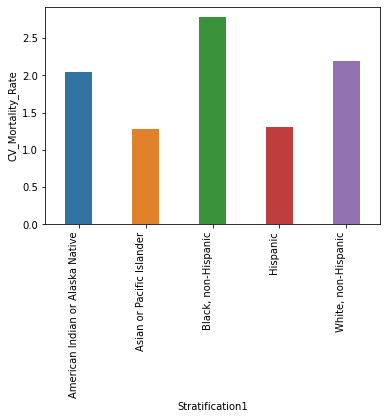

In [44]:
fig, ax = plt.subplots()
race_mort_plot = sns.barplot(x="Stratification1", y="CV_Mortality_Rate", data=race_mortality)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .4)
race_mort_plot.set_xticklabels(race_mort_plot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

In [45]:
# average of male + female sex % by year
gender_year_group = data_fem.groupby('YearStart')[['Male Sex %', 'Female Sex %']].mean()
gender_year_group.reset_index(inplace=True)
gender_year_group = gender_year_group.rename(columns = {'index':'YearStart'})
gender_year_group

YearStart  Male Sex %  Female Sex %
0       2010   48.872687     51.127313
1       2011   48.920478     51.079522
2       2012   48.961073     51.038927
3       2013   48.983043     51.016957
4       2014   48.975817     51.024183
5       2015   48.963270     51.036730
6       2016   49.017915     50.982085
7       2017   49.000092     50.999908
8       2018   48.986698     51.013302

In [46]:
#reformat dataframe to plot
tidy = gender_year_group.melt(id_vars='YearStart',var_name='sex',value_name='rate')
tidy[['rate']] = tidy[['rate']]
tidy[['rate']] = tidy[['rate']].astype(int)
tidy

YearStart           sex  rate
0        2010    Male Sex %    48
1        2011    Male Sex %    48
2        2012    Male Sex %    48
3        2013    Male Sex %    48
4        2014    Male Sex %    48
5        2015    Male Sex %    48
6        2016    Male Sex %    49
7        2017    Male Sex %    49
8        2018    Male Sex %    48
9        2010  Female Sex %    51
10       2011  Female Sex %    51
11       2012  Female Sex %    51
12       2013  Female Sex %    51
13       2014  Female Sex %    51
14       2015  Female Sex %    51
15       2016  Female Sex %    50
16       2017  Female Sex %    50
17       2018  Female Sex %    51

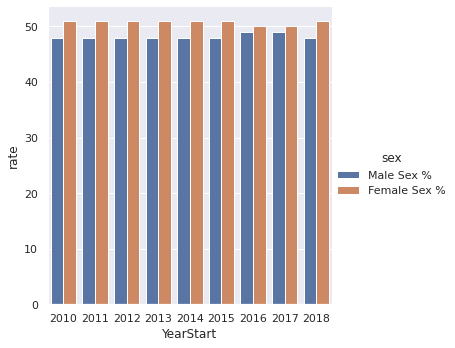

In [51]:
#rate of cardiovascular mortality in the U.S. by gender

sns.set(rc = {'figure.figsize':(100,100)})
sns.catplot(x='YearStart',y='rate',hue='sex',data=tidy,kind='bar')

# Comparing GLM and non-parametric methods: DT/RF

In [52]:
cleaned_data

YearStart LocationDesc DataValue                   Stratification1  \
165005       2012       Alaska     126.2         Asian or Pacific Islander   
165075       2011      Arizona     174.7  American Indian or Alaska Native   
165199       2013      Arizona     262.2               Black, non-Hispanic   
165264       2014      Arizona     185.2               White, non-Hispanic   
165314       2010      Alabama     297.3               White, non-Hispanic   
...           ...          ...       ...                               ...   
192372       2010     Kentucky     102.3                          Hispanic   
192378       2013  Mississippi     204.7  American Indian or Alaska Native   
192381       2016     Arkansas      94.6                          Hispanic   
192394       2018       Hawaii     153.8               Black, non-Hispanic   
192405       2013   New Mexico     103.7         Asian or Pacific Islander   

        Stratification_American Indian or Alaska Native  \
165005                                                0   
165075                                                1   
165199                                                0   
165264                                                0   
165314                                                0   
...                                                 ...   
192372                                                0   
192378                                                1   
192381                                                0   
192394                                                0   
192405                                                0   

        Stratification_Asian or Pacific Islander  \
165005                                         1   
165075                                         0   
165199                                         0   
165264                                         0   
165314                                         0   
...                                          ...   
192372                                         0   
192378                                         0   
192381                                         0   
192394                                         0   
192405                                         1   

        Stratification_Black, non-Hispanic  Stratification_Hispanic  \
165005                                   0                        0   
165075                                   0                        0   
165199                                   1                        0   
165264                                   0                        0   
165314                                   0                        0   
...                                    ...                      ...   
192372                                   0                        1   
192378                                   0                        0   
192381                                   0                        1   
192394                                   1                        0   
192405                                   0                        0   

        Stratification_White, non-Hispanic  Diabetes Rate  \
165005                                   0            7.2   
165075                                   0            9.0   
165199                                   0            9.8   
165264                                   1            9.1   
165314                                   1           11.3   
...                                    ...            ...   
192372                                   0            9.3   
192378                                   0           12.0   
192381                                   0           12.1   
192394                                   0           10.3   
192405                                   0            9.8   

        Tobacco Consumption Rate  Obesity Rate  PM2.5 Level - Annual Mean  \
165005                  1.589690     25.700000                   5.069902 

In [55]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(cleaned_data,test_size=.3, random_state = 4)

In [54]:
#IF a poisson distribution was good for mortality rates, then the mean and variance would be close
#since its not, poisson distribution is NOT a good fit for age-related mortality rates
np.mean(cleaned_data.DataValue), np.var(cleaned_data.DataValue)


(193.44498673740063, 5692.092045158975)

#### GLMs

## Poisson 

### Race and Year

### Race 

In [ ]:
#Frequentist GLM - Poisson (race ONLY)
y = (cleaned_data.DataValue).astype(None)
poisson_model_race = sm.GLM(
    y, sm.add_constant(cleaned_data[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic']]),
    family=sm.families.Poisson()
)
poisson_results_race = poisson_model_race.fit()
print(poisson_results_race.summary())

#Again: same problem, low standard of error, model is too confident. Can conclude poisson distribution is not a good fit for this data
# We will try this again with location once we use medicaid expenditure, etc. as features

                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                 1885
Model:                            GLM   Df Residuals:                     1880
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18045.
Date:                Mon, 13 Dec 2021   Deviance:                       22850.
Time:                        16:26:07   Pearson chi2:                 2.28e+04
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### Race, Medicare Expenditure, and Year

In [ ]:
#Frequentist GLM - Poisson (race + medicare expenditure + year)

poisson_model_race_medicare_year = sm.GLM(
    y, sm.add_constant(cleaned_data[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Medicare Expenditure', 'YearStart']]),
    family=sm.families.Poisson()
)
poisson_results_race_medicare_year = poisson_model_race_medicare_year.fit()
print(poisson_results_race_medicare_year.summary())

#Again: non-significant p-values; too wide confidence intervals this time; log-likelihood & Chi2

                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                 1885
Model:                            GLM   Df Residuals:                     1878
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17884.
Date:                Mon, 13 Dec 2021   Deviance:                       22529.
Time:                        16:26:13   Pearson chi2:                 2.24e+04
No. Iterations:                     4   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### Race, Medicare Expenditure, Year, and Gender

In [ ]:
#Frequentist GLM - Poisson (race + medicare expenditure + year + gender)
poisson_model_race_medicare_year_gender = sm.GLM(
    y, sm.add_constant(cleaned_data[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Medicare Expenditure', 'YearStart', 'Male Sex %']]),
    family=sm.families.Poisson()
)
poisson_results_race_medicare_year_gender = poisson_model_race_medicare_year_gender.fit()
print(poisson_results_race_medicare_year_gender.summary())

#very low standard error for Medical Expenditure, adding gender does not improve the fit of the model

                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                 1885
Model:                            GLM   Df Residuals:                     1877
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17800.
Date:                Mon, 13 Dec 2021   Deviance:                       22360.
Time:                        16:26:17   Pearson chi2:                 2.23e+04
No. Iterations:                     4   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

## Negative Binomial 

### Race and Year 

In [ ]:
#Frequent GLM - Negative Binomial (race + year)
negbin_model_raceyear = sm.GLM(
    y, sm.add_constant(cleaned_data[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'YearStart']]),
    family=sm.families.NegativeBinomial()
)
negbin_results_raceyear = negbin_model_raceyear.fit()
print(negbin_results_raceyear.summary())

#non-significant p-values, too wide confidence intervals, high standard errors

                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                 1885
Model:                            GLM   Df Residuals:                     1879
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11728.
Date:                Mon, 13 Dec 2021   Deviance:                       126.36
Time:                        16:26:31   Pearson chi2:                     122.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08798
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### Race

In [ ]:
#Frequentist Model - Negative Binomial (race only)
negbin_model_race = sm.GLM(
    y, sm.add_constant(cleaned_data[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic']]),
    family=sm.families.NegativeBinomial()
)
negbin_results_race = negbin_model_race.fit()
print(negbin_results_race.summary())
#log-likelihood was okay, avg log-likelihood of -6, log-likelihoods close to 0 are good.
#Chi-square statistic & deviance should be less than n-p, it WAS !
# roughly be n - p = 1885 - 5 = 1880 but instead is 123, since its less, better fit!)

#confidence intervals & standard erros are a bit TOO small so model might be overconfident

                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                 1885
Model:                            GLM   Df Residuals:                     1880
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11728.
Date:                Sun, 12 Dec 2021   Deviance:                       127.52
Time:                        03:34:17   Pearson chi2:                     123.
No. Iterations:                   100   Pseudo R-squ. (CS):            0.08742
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### Race and Medicare Expenditure 

In [ ]:
#Frequentist Model - Negative Binomial (race + expenditure)

negbin_model_race_medicare = sm.GLM(
    y, sm.add_constant(cleaned_data[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Medicare Expenditure']]),
    family=sm.families.NegativeBinomial()
)
negbin_results_race_medicare = negbin_model_race_medicare.fit()
print(negbin_results_race_medicare.summary())

#Similar idea for deviance / chi2 / log-likelihood --> seem good
#Medicare expenditure had very little impact and it seems like race is a much bigger deal than 
# state differences in medicare expenditure

                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                 1885
Model:                            GLM   Df Residuals:                     1879
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11727.
Date:                Sun, 12 Dec 2021   Deviance:                       125.35
Time:                        03:34:17   Pearson chi2:                     120.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08847
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### Race, Medicare Expenditure, and Year

In [ ]:
#Frequentist Model - Negative Binomial (race + expenditure + year)
negbin_model_race_medicare_year = sm.GLM(
    y, sm.add_constant(cleaned_data[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Medicare Expenditure', 'YearStart']]),
    family=sm.families.NegativeBinomial()
)
negbin_results_race_medicare_year = negbin_model_race_medicare_year.fit()
print(negbin_results_race_medicare_year.summary())

#Similar idea for deviance / chi2 / log-likelihood --> seem good
#Medicare expenditure had very little impact, same with year. 
# confidence intervals are TOO wide so this was not good


                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                 1885
Model:                            GLM   Df Residuals:                     1878
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11727.
Date:                Sun, 12 Dec 2021   Deviance:                       124.94
Time:                        03:34:17   Pearson chi2:                     120.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08867
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### Gender and Year

In [ ]:
#Frequentist Model - Negative Binomial (gender + year)
negbin_model_gender_year = sm.GLM(
    y, sm.add_constant(cleaned_data[['Male Sex %', 'YearStart']]),
    family=sm.families.NegativeBinomial()
)
negbin_results_gender_year = negbin_model_gender_year.fit()
print(negbin_results_gender_year.summary())

#wide confidence intervals

                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                 1885
Model:                            GLM   Df Residuals:                     1882
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11813.
Date:                Sun, 12 Dec 2021   Deviance:                       297.03
Time:                        03:34:17   Pearson chi2:                     286.
No. Iterations:                     5   Pseudo R-squ. (CS):           0.001550
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.7837     18.020      1.320      0.1

### Race, Gender, and Year

In [ ]:
#Frequentist Model - Negative Binomial (race + gender + year)
negbin_model_gender_race_year = sm.GLM(
    y, sm.add_constant(cleaned_data[['Male Sex %', 'YearStart','Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic']]),
    family=sm.families.NegativeBinomial()
)
negbin_results_gender_race_year = negbin_model_gender_race_year.fit()
print(negbin_results_gender_race_year.summary())

#Too wide of confidence interval; non-significant p-values

                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                 1885
Model:                            GLM   Df Residuals:                     1878
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11726.
Date:                Sun, 12 Dec 2021   Deviance:                       123.02
Time:                        03:34:17   Pearson chi2:                     120.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08959
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### Race, Gender, Medicare Expenditure, and Year

In [ ]:
#Frequentist Model - Negative Binomial (race + gender + expenditure + year)
negbin_model_gender_race_expenditure_year = sm.GLM(
    y, sm.add_constant(cleaned_data[['Male Sex %', 'YearStart','Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Medicare Expenditure']]),
    family=sm.families.NegativeBinomial()
)
negbin_results_gender_race_expenditure_year = negbin_model_gender_race_expenditure_year.fit()
print(negbin_results_gender_race_expenditure_year.summary())

#this was bad: confidence intervals were too wide and it was hard to make any inference on this.

                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                 1885
Model:                            GLM   Df Residuals:                     1877
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11726.
Date:                Sun, 12 Dec 2021   Deviance:                       122.98
Time:                        03:34:17   Pearson chi2:                     120.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08961
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [ ]:
#Frequentist Model - Negative Binomial (race + gender + diabetes)
negbin_model_gender_race_diab = sm.GLM(
    y, sm.add_constant(cleaned_data[['Male Sex %', 'Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Diabetes Rate']]),
    family=sm.families.NegativeBinomial()
)
negbin_results_gender_race_diab = negbin_model_gender_race_diab.fit()
print(negbin_results_gender_race_diab.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                 1885
Model:                            GLM   Df Residuals:                     1878
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11726.
Date:                Mon, 13 Dec 2021   Deviance:                       122.89
Time:                        17:57:42   Pearson chi2:                     119.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08966
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [ ]:
#Frequentist Model - Negative Binomial (race + gender + diabetes + obesity)
negbin_model_gender_race_diab_obs = sm.GLM(
    y, sm.add_constant(cleaned_data[['Male Sex %', 'Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Diabetes Rate', 'Obesity Rate']]),
    family=sm.families.NegativeBinomial()
)
negbin_results_gender_race_diab_obs = negbin_model_gender_race_diab_obs.fit()
print(negbin_results_gender_race_diab_obs.summary())

NameError: name 'y' is not defined

In [ ]:
#Frequentist Model - Negative Binomial (all)
negbin_model_gender_race_diab_obs = sm.GLM(
    y, sm.add_constant(cleaned_data[['Male Sex %', 'Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Medicare Expenditure', 'Diabetes Rate', 'Obesity Rate', 'Tobacco Consumption Rate']]),
    family=sm.families.NegativeBinomial()
)
negbin_results_gender_race_diab_obs = negbin_model_gender_race_diab_obs.fit()
print(negbin_results_gender_race_diab_obs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                 1885
Model:                            GLM   Df Residuals:                     1875
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11725.
Date:                Mon, 13 Dec 2021   Deviance:                       122.02
Time:                        17:59:25   Pearson chi2:                     117.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.09008
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

# Decision Trees

## Race

In [ ]:
#predicting mortality rate based on race
from sklearn.tree import DecisionTreeRegressor

race_tree_model = DecisionTreeRegressor() 
X_train = train[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic']]
X_test = test[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic']]
y_train = train['DataValue'] 
y_test = test['DataValue']
race_tree_model.fit(X_train,y_train) 

train["race_tree_pred"] = race_tree_model.predict(X_train)
test["race_tree_pred"] = race_tree_model.predict(X_test)

In [ ]:
#RMSE for race predictor
train_rmse = np.mean((train["race_tree_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["race_tree_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 50.207348968537
Test set error for decision tree:     45.59776047690627


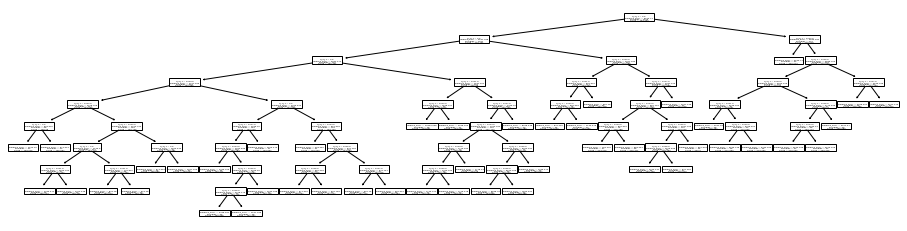

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(16, 4))
plot_tree(race_tree_model);

## Medicare Expenditure

In [ ]:
#predicting mortality rate based on medicare expenditure 
from sklearn.tree import DecisionTreeRegressor

medicare_tree_model = DecisionTreeRegressor() 
y_train = train['DataValue'] 
y_test = train['DataValue']
X_train = train[['Medicare Expenditure']]
X_test = test[['Medicare Expenditure']]
medicare_tree_model.fit(X_train,y_train) 

train["medicare_tree_pred"] = medicare_tree_model.predict(X_train)
test["medicare_tree_pred"] = medicare_tree_model.predict(X_test)

In [ ]:
#RMSE for expenditure predictor
train_rmse = np.mean((train["medicare_tree_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["medicare_tree_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 66.00607556447662
Test set error for decision tree:     96.51548242376563


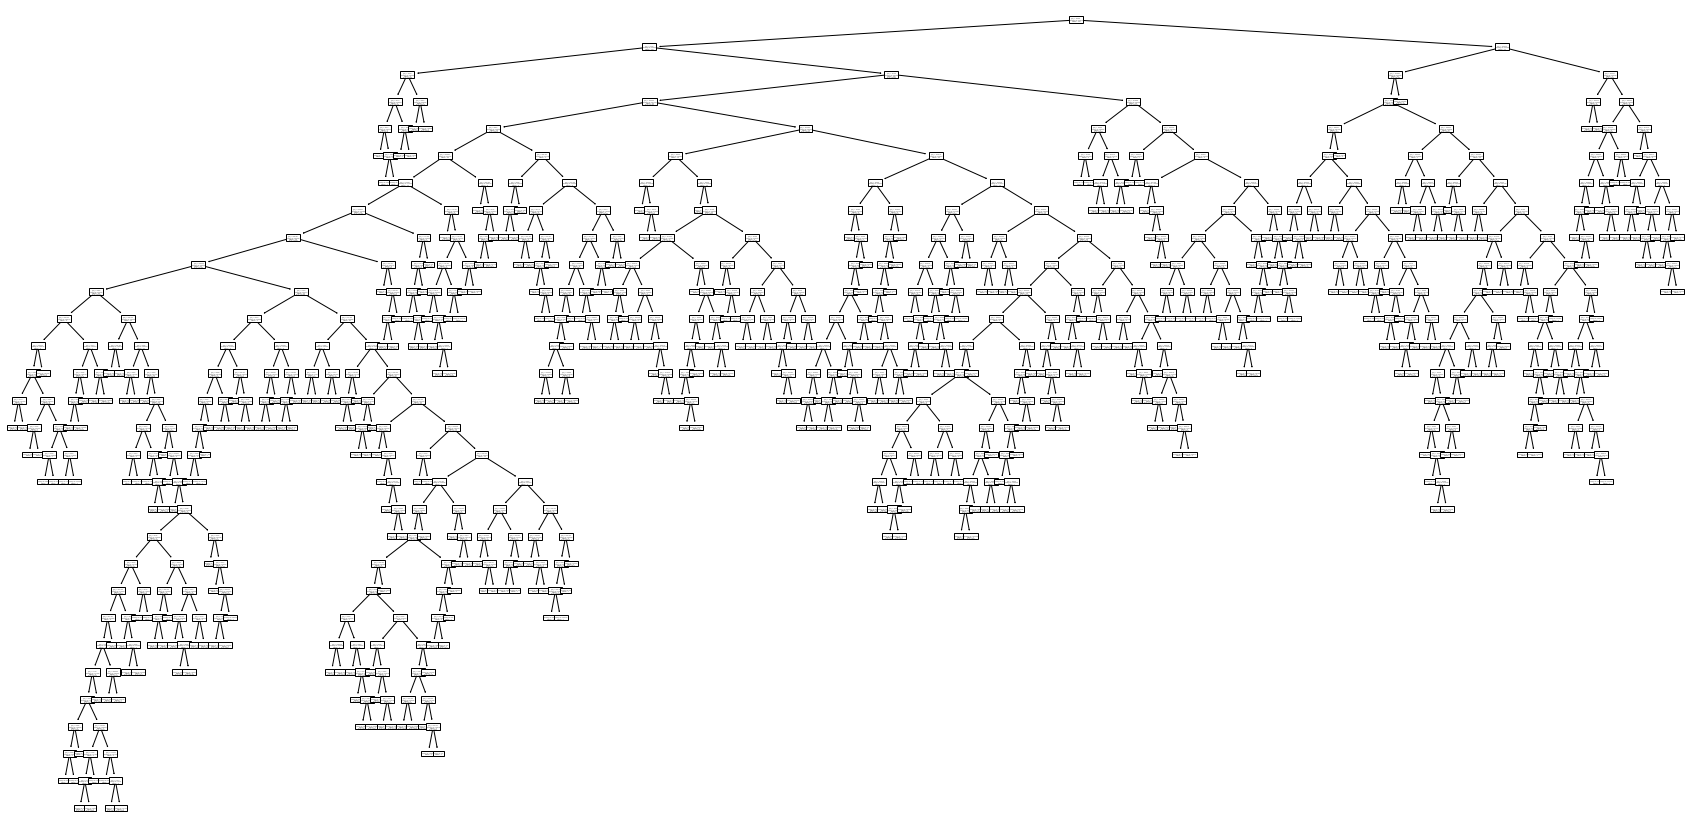

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(50, 50))
plot_tree(medicare_tree_model);

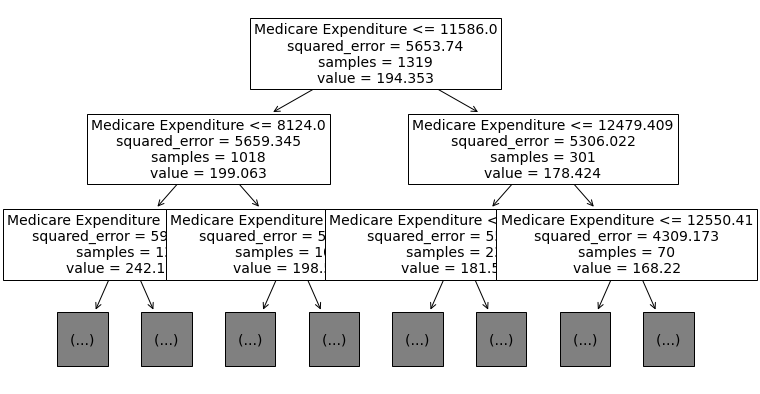

In [ ]:
#closer look of nodes at the top
X_cols = ['Medicare Expenditure']
plt.figure(figsize=(12, 7))
plot_tree(medicare_tree_model, max_depth=2, fontsize=14, feature_names=X_cols);

## Year

In [ ]:
#predicting mortality rate based on year 
from sklearn.tree import DecisionTreeRegressor

year_tree_model = DecisionTreeRegressor() 
y_train = train['DataValue'] 
y_test = train['DataValue']
X_train = train[['YearStart']]
X_test = test[['YearStart']]
year_tree_model.fit(X_train,y_train) 

train["year_tree_pred"] = year_tree_model.predict(X_train)
test["year_tree_pred"] = year_tree_model.predict(X_test)

In [ ]:
#RMSE for year predictor
train_rmse = np.mean((train["year_tree_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["year_tree_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 74.98326791176589
Test set error for decision tree:     76.06123942324884


In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(50, 50))
plot_tree(year_tree_model);

## Race and Medicare Expenditure

In [ ]:
#predicting mortality from race + expenditure 
from sklearn.tree import DecisionTreeRegressor

medicare_race_tree_model = DecisionTreeRegressor() 
y_train = train['DataValue'] 
y_test = train['DataValue']
X_train = train[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic','Medicare Expenditure']]
X_test = test[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic','Medicare Expenditure']]
medicare_race_tree_model.fit(X_train,y_train) 

train["medicare_race_tree_pred"] = medicare_race_tree_model.predict(X_train)
test["medicare_race_tree_pred"] = medicare_race_tree_model.predict(X_test)

In [ ]:
#RMSE for race + expenditure predictor
train_rmse = np.mean((train["medicare_race_tree_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["medicare_race_tree_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 7.373723145400766
Test set error for decision tree:     60.44698820778606


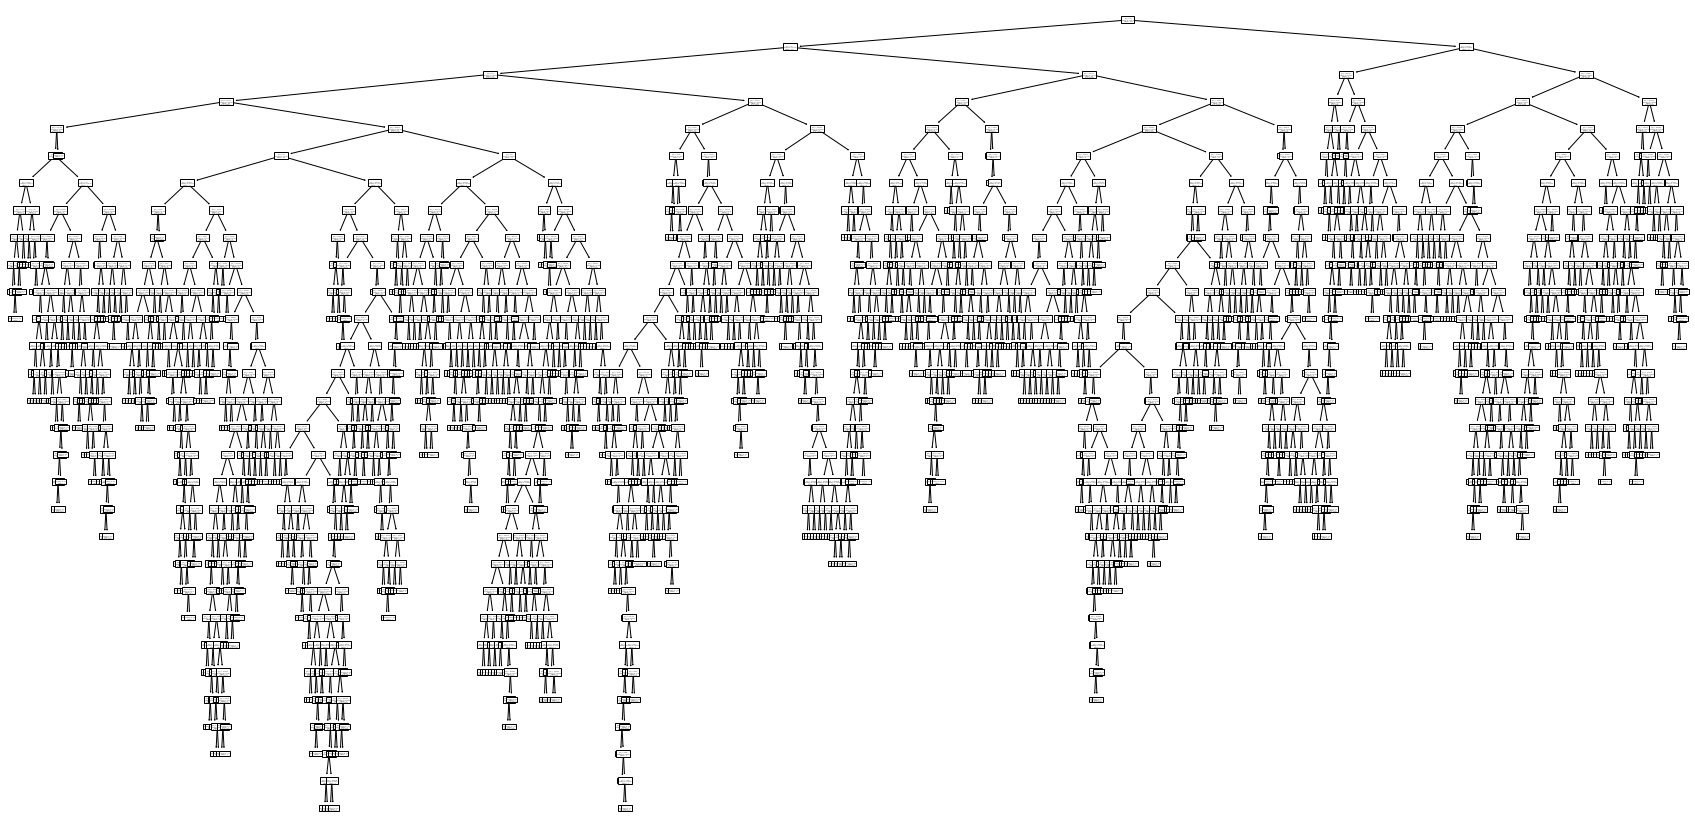

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30, 15))
plot_tree(medicare_race_tree_model);

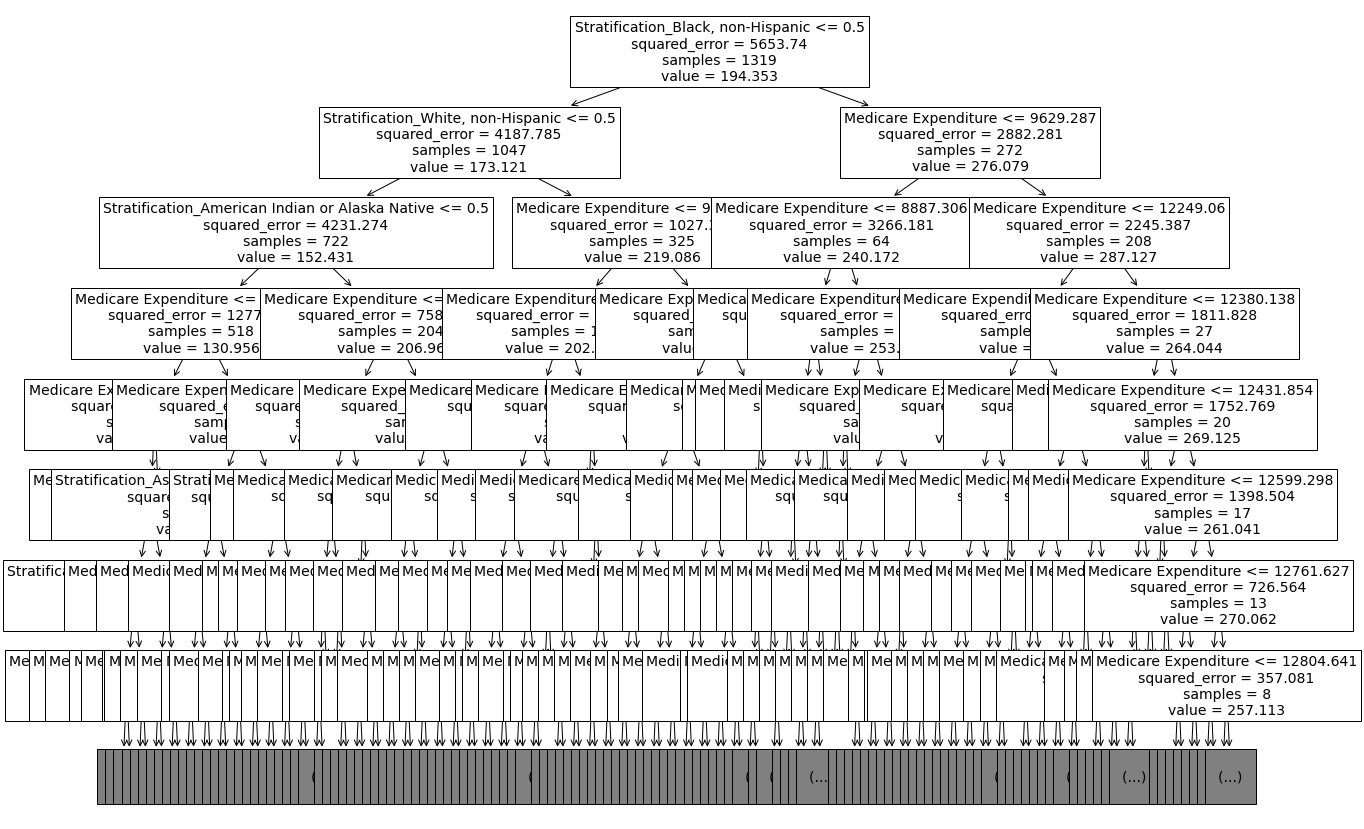

In [ ]:
#closer look at nodes
X_cols = ['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic','Medicare Expenditure']
plt.figure(figsize=(20, 15))
plot_tree(medicare_race_tree_model, max_depth=7, fontsize=14, feature_names=X_cols);

## Gender

In [ ]:
#predicting mortality from gender 
from sklearn.tree import DecisionTreeRegressor

gender_tree_model = DecisionTreeRegressor() 
y_train = train['DataValue'] 
y_test = train['DataValue']
X_train = train[['Male Sex %']]
X_test = test[['Male Sex %']]
gender_tree_model.fit(X_train,y_train) 

train["gender_tree_pred"] = gender_tree_model.predict(X_train)
test["gender_tree_pred"] = gender_tree_model.predict(X_test)

In [ ]:
#RMSE for gender predictor
train_rmse = np.mean((train["gender_tree_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["gender_tree_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 69.38684017944782
Test set error for decision tree:     87.35505310374847


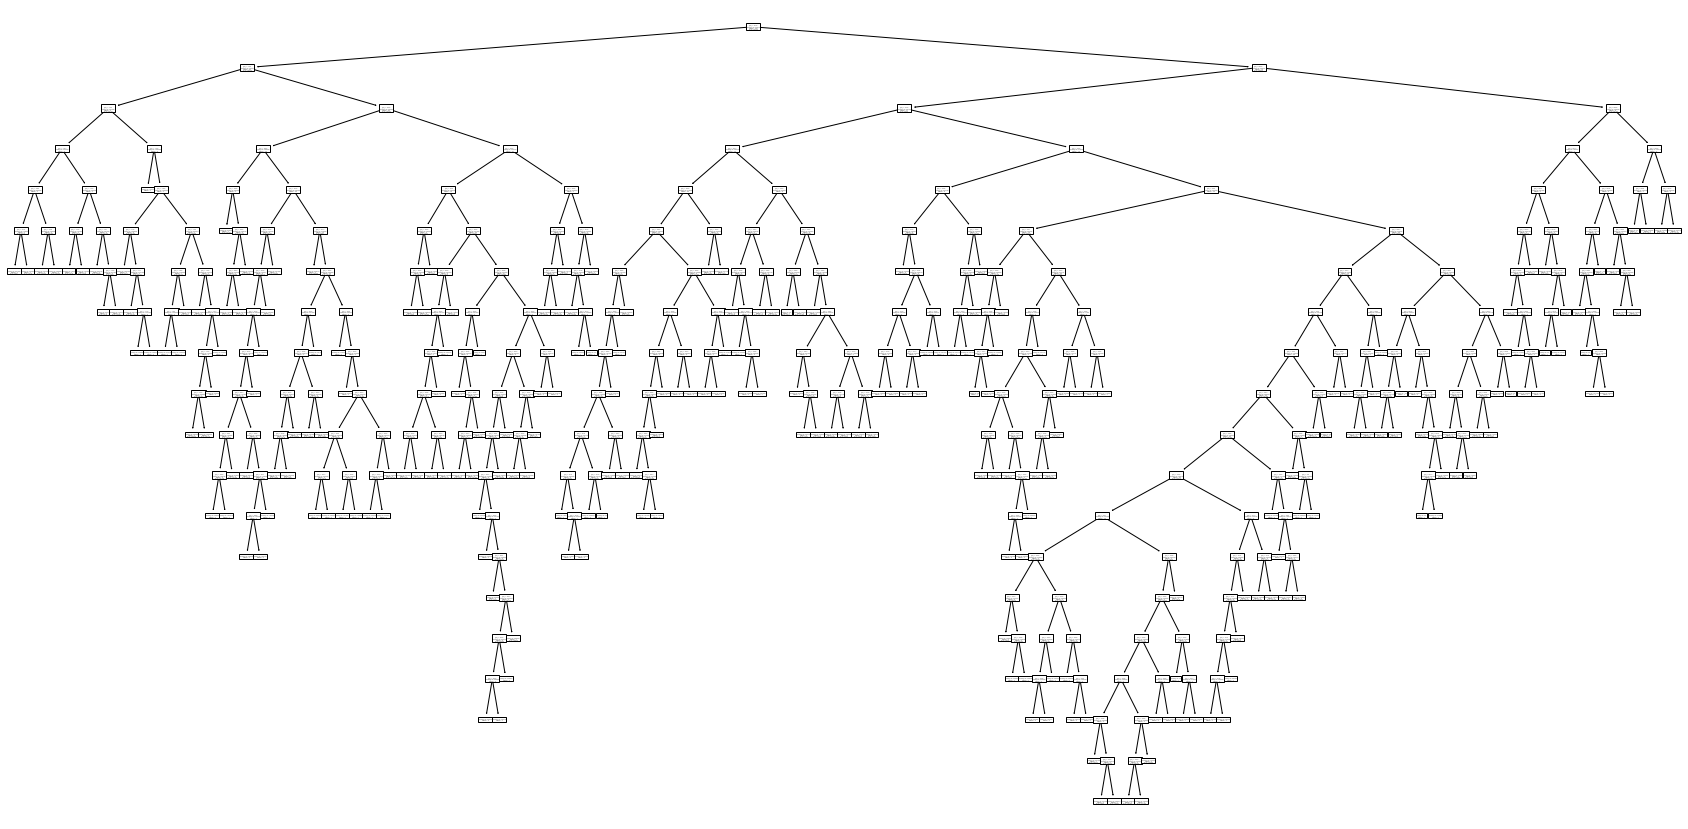

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30, 15))
plot_tree(gender_tree_model);

## Diabetes

In [ ]:
#predicting mortality from diabetes 
from sklearn.tree import DecisionTreeRegressor

diabetes_tree_model = DecisionTreeRegressor() 
y_train = train['DataValue'] 
y_test = train['DataValue']
X_train = train[['Diabetes Rate']]
X_test = test[['Diabetes Rate']]
diabetes_tree_model.fit(X_train,y_train) 

train["diabetes_tree_pred"] = diabetes_tree_model.predict(X_train)
test["diabetes_tree_pred"] = diabetes_tree_model.predict(X_test)

In [ ]:
#RMSE for diabetes predictor
train_rmse = np.mean((train["diabetes_tree_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["diabetes_tree_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 73.6039035280007
Test set error for decision tree:     79.8745515752153


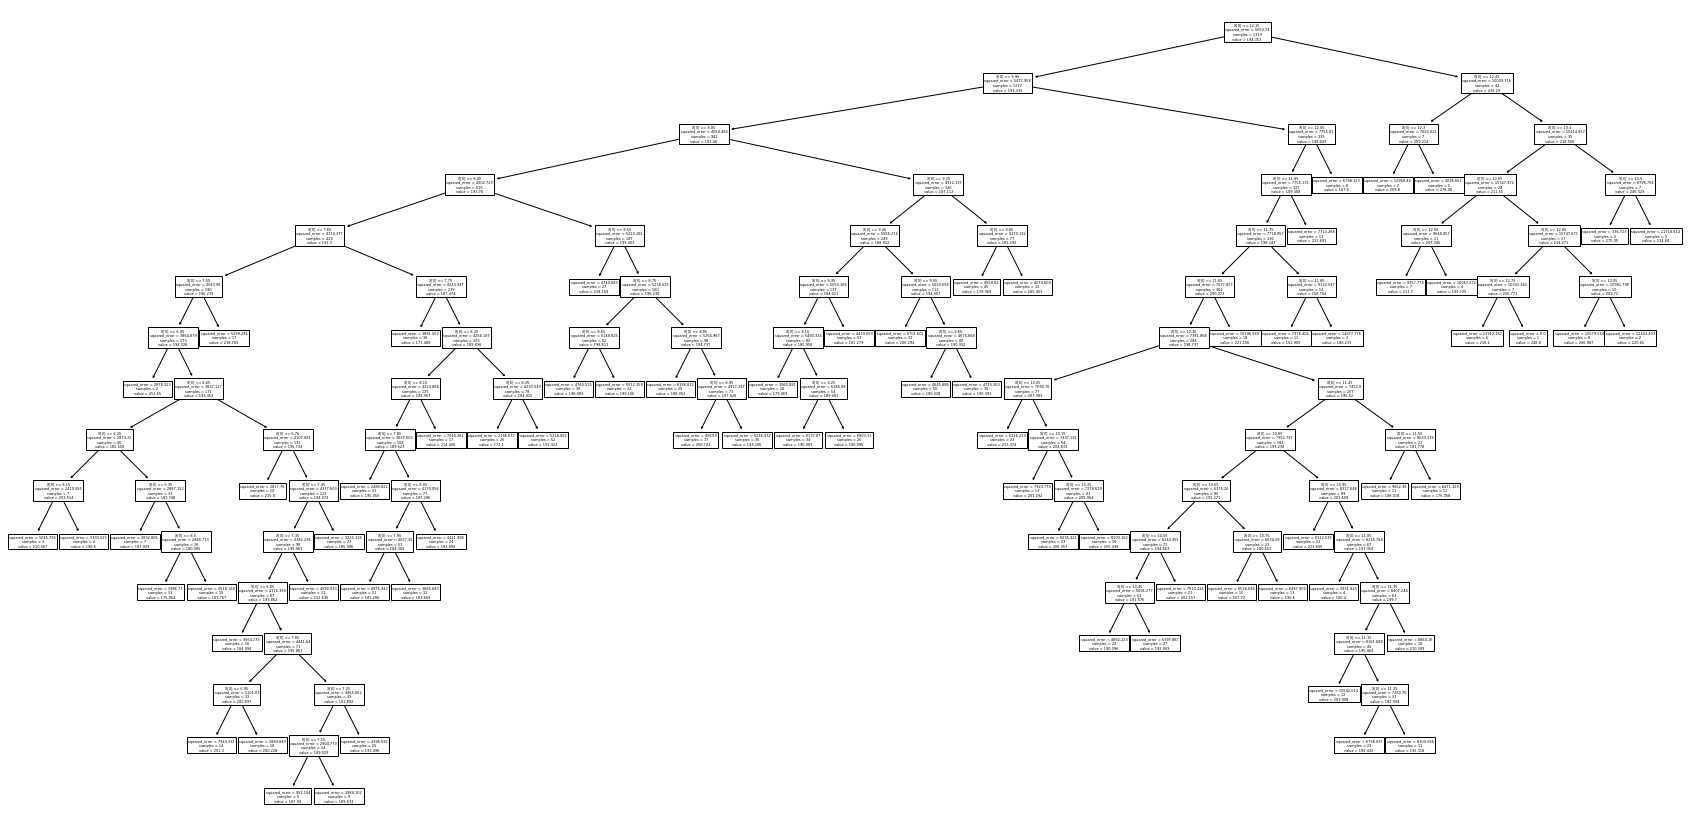

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30, 15))
plot_tree(diabetes_tree_model);

## Obesity

In [ ]:
#predicting mortality from obesity 
from sklearn.tree import DecisionTreeRegressor

obesity_tree_model = DecisionTreeRegressor() 
y_train = train['DataValue'] 
y_test = train['DataValue']
X_train = train[['Obesity Rate']]
X_test = test[['Obesity Rate']]
obesity_tree_model.fit(X_train,y_train) 

train["obesity_tree_pred"] = obesity_tree_model.predict(X_train)
test["obesity_tree_pred"] = obesity_tree_model.predict(X_test)

In [ ]:
#RMSE for obesity predictor
train_rmse = np.mean((train["obesity_tree_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["obesity_tree_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 71.16971990507128
Test set error for decision tree:     83.55849429173414


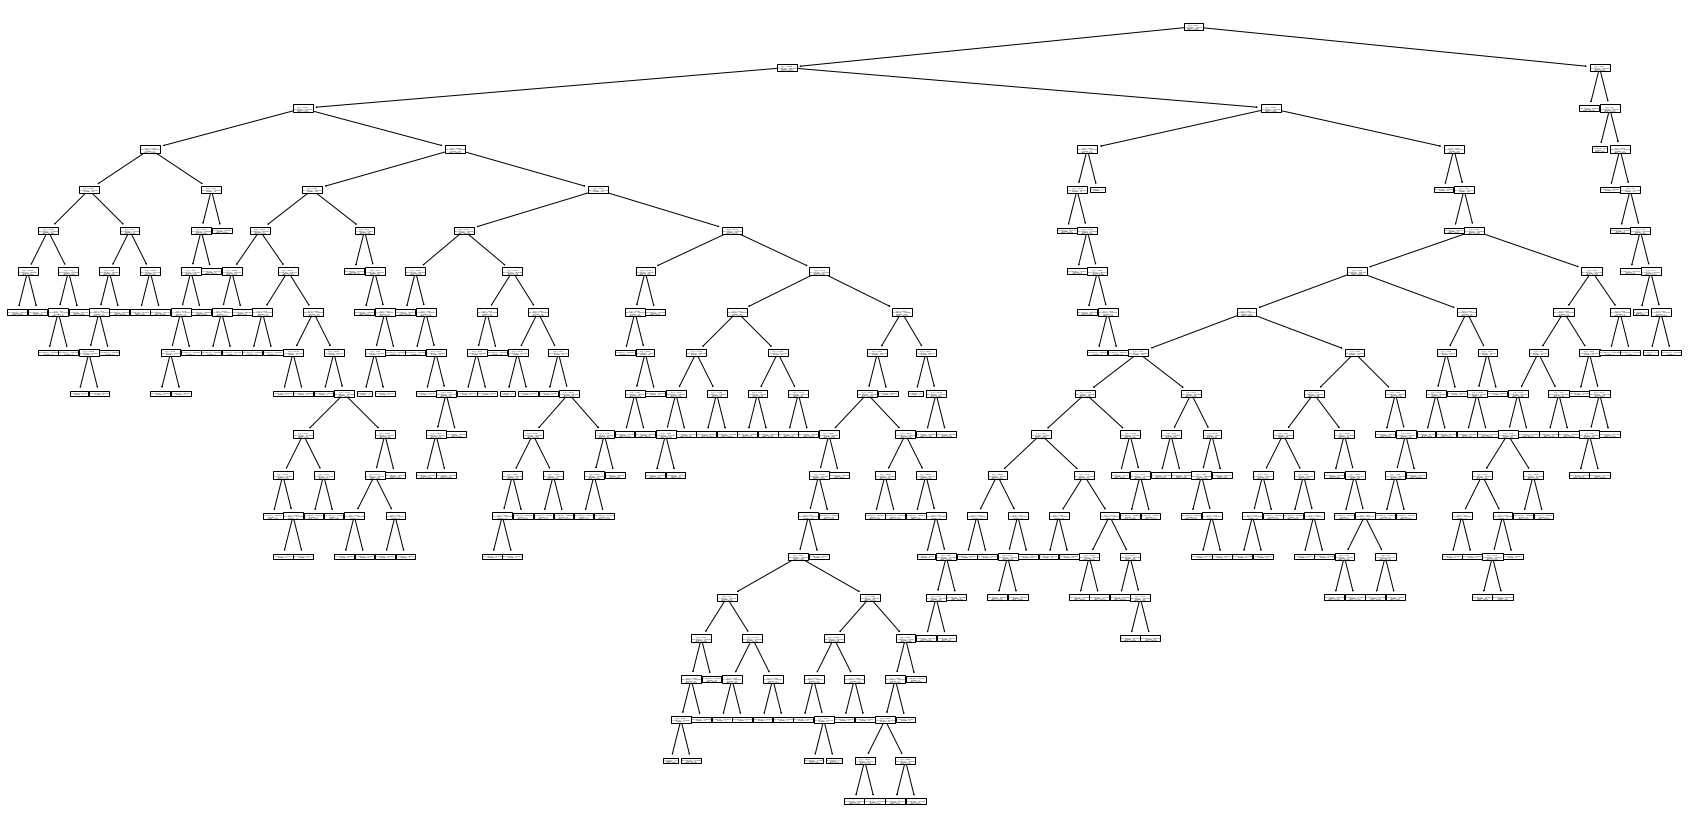

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30, 15))
plot_tree(obesity_tree_model);

## Gender and Year

In [ ]:
#predicting mortality from gender and year 
from sklearn.tree import DecisionTreeRegressor

gender_year_tree_model = DecisionTreeRegressor() 
y_train = train['DataValue'] 
y_test = train['DataValue']
X_train = train[['Male Sex %', 'YearStart']]
X_test = test[['Male Sex %', 'YearStart']]
gender_year_tree_model.fit(X_train,y_train) 

train["gender_year_tree_pred"] = gender_year_tree_model.predict(X_train)
test["gender_year_tree_pred"] = gender_year_tree_model.predict(X_test)

In [ ]:
#RMSE for gender and year predictor
train_rmse = np.mean((train["gender_year_tree_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["gender_year_tree_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 65.62327117348332
Test set error for decision tree:     97.20341483877479


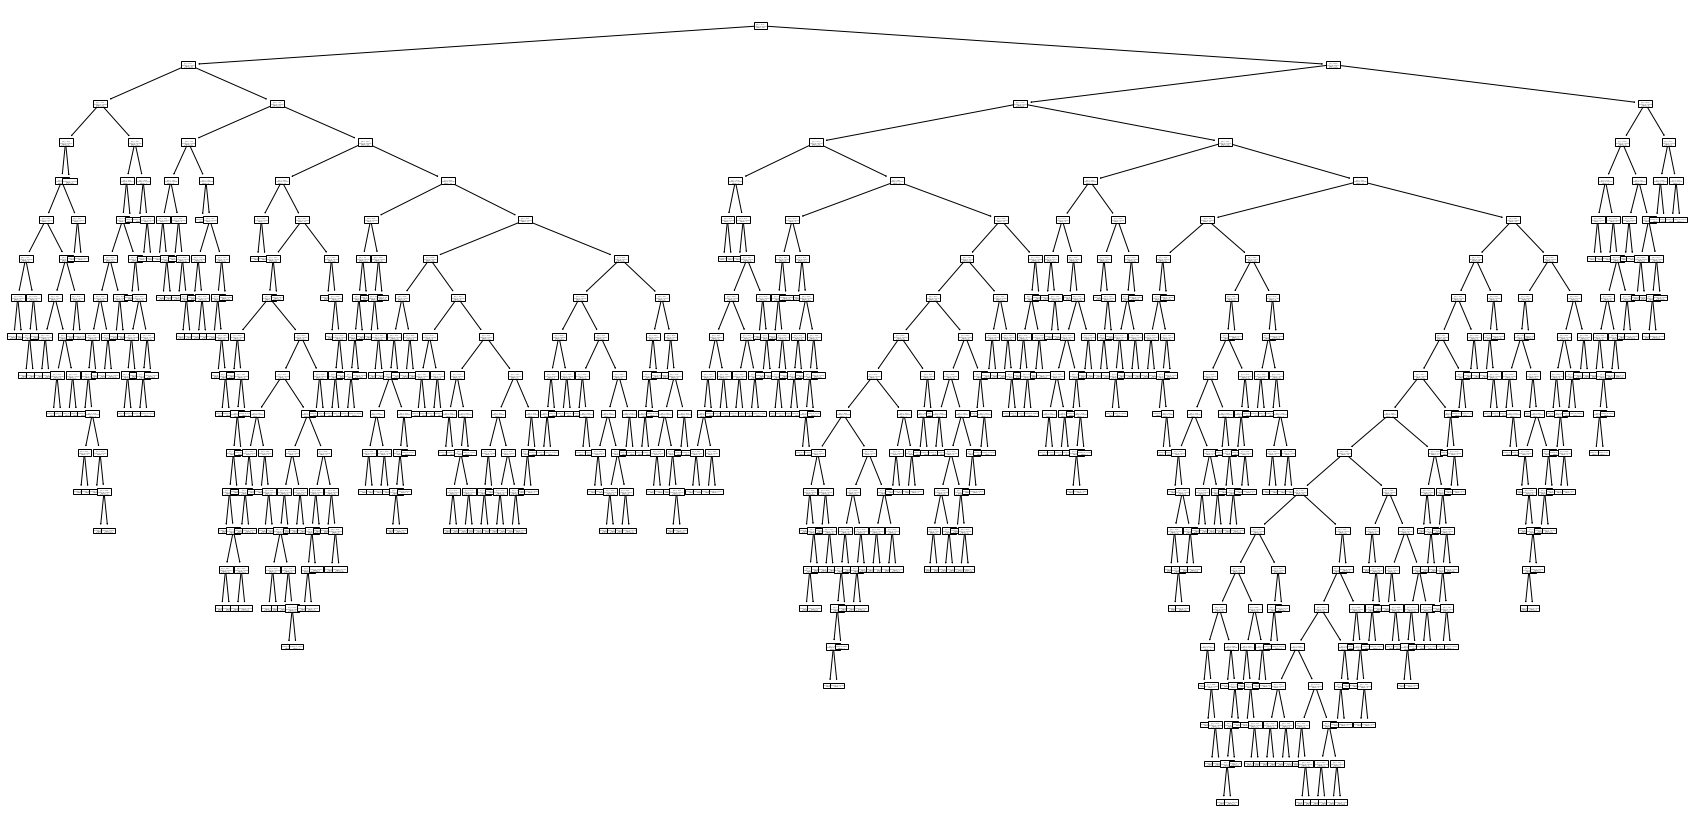

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30, 15))
plot_tree(gender_year_tree_model);

## Gender and Medicare Expenditure 

In [ ]:
#predicting mortality from gender and medicare 
from sklearn.tree import DecisionTreeRegressor

gender_medicare_tree_model = DecisionTreeRegressor() 
y_train = train['DataValue'] 
y_test = train['DataValue']
X_train = train[['Male Sex %','Medicare Expenditure']]
X_test = test[['Male Sex %','Medicare Expenditure']]
gender_medicare_tree_model.fit(X_train,y_train) 

train["gender_medicare_pred"] = gender_medicare_tree_model.predict(X_train)
test["gender_medicare_pred"] = gender_medicare_tree_model.predict(X_test)

In [ ]:
#RMSE for gender and medicare predictor
train_rmse = np.mean((train["gender_medicare_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["gender_medicare_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 65.14973499797054
Test set error for decision tree:     98.67838917408979


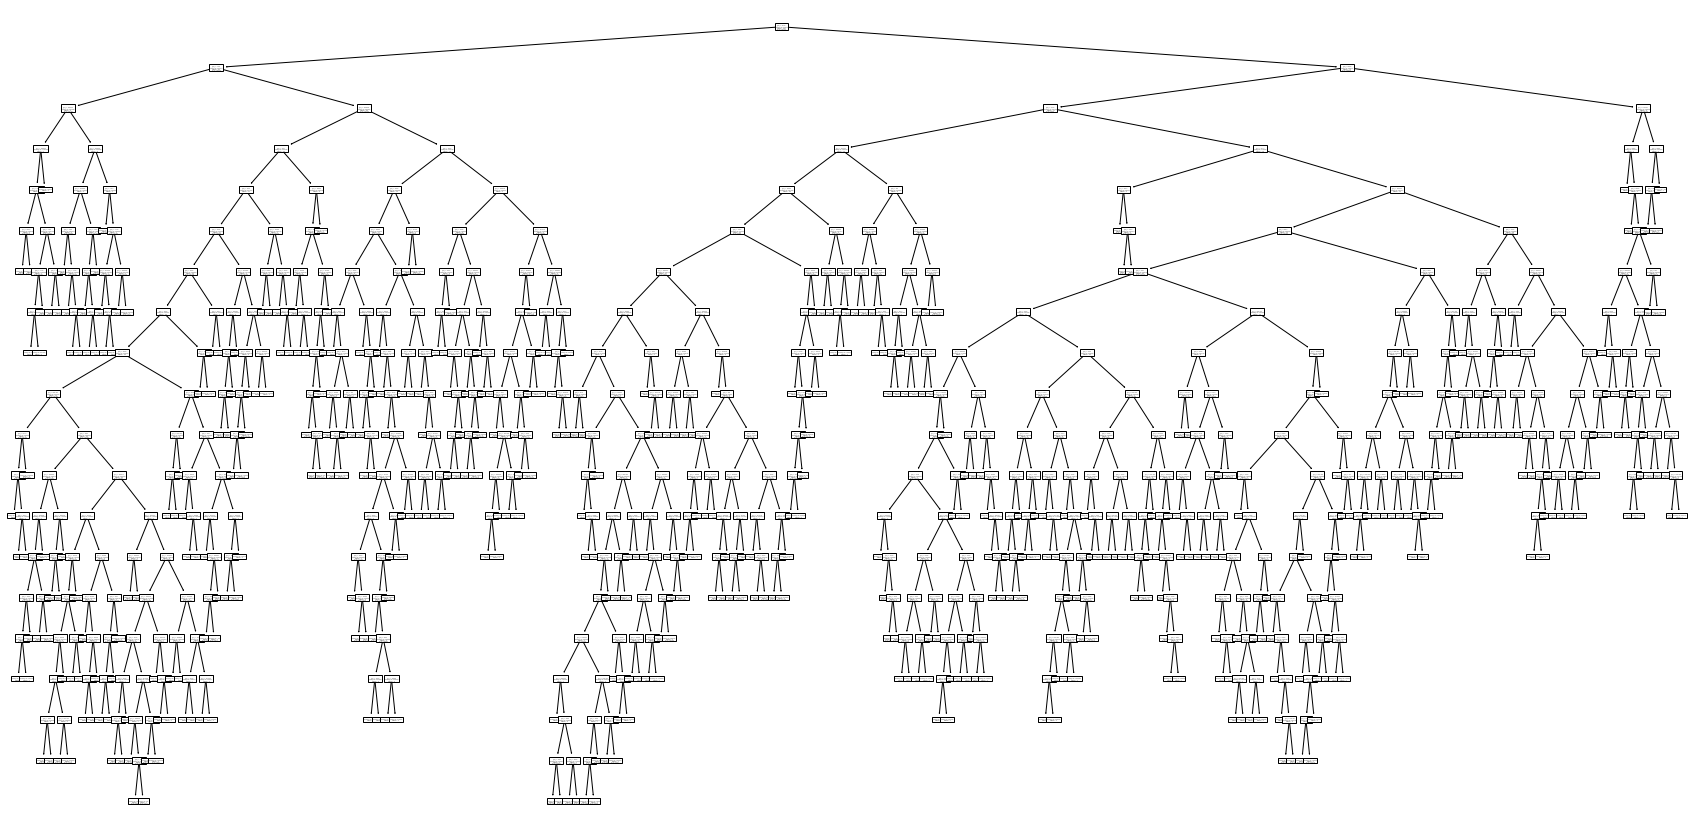

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30, 15))
plot_tree(gender_medicare_tree_model);

## Race, Gender, Year, and Medicare Expenditure

In [ ]:
#predicting mortality rate based on race, gender, year and medicare
from sklearn.tree import DecisionTreeRegressor

gender_race_medicare_year_tree_model = DecisionTreeRegressor() 
X_train = train[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'YearStart',
       'Male Sex %','Medicare Expenditure']]
X_test = test[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'YearStart',
       'Male Sex %','Medicare Expenditure']]
y_train = train['DataValue'] 
y_test = test['DataValue']
gender_race_medicare_year_tree_model.fit(X_train,y_train) 

train["gender_race_medicare_year_tree_pred"] = gender_race_medicare_year_tree_model.predict(X_train)
test["gender_race_medicare_year_tree_pred"] = gender_race_medicare_year_tree_model.predict(X_test)

In [ ]:
#RMSE for gender, race, year, and medicare predictor
#overfitting bc training set error is 0 but test error is low
train_rmse = np.mean((train["gender_race_medicare_year_tree_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["gender_race_medicare_year_tree_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 0.0
Test set error for decision tree:     48.14613594423154


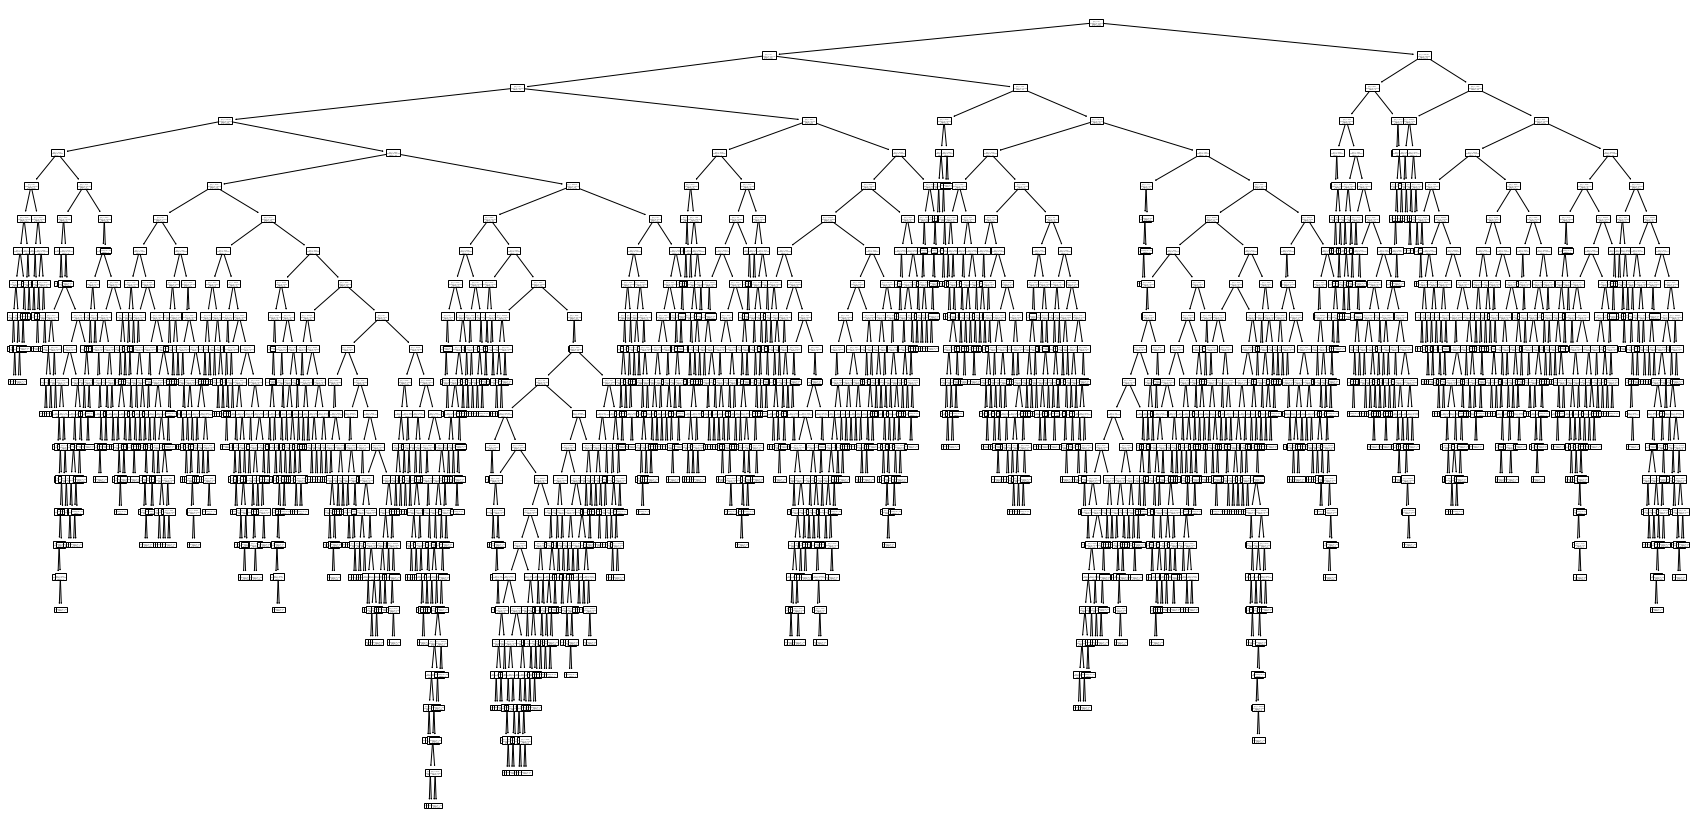

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30, 15))
plot_tree(gender_race_medicare_year_tree_model);

## All  Features (Race, Gender, Medicare, Year, Diabetes, and Obesity)

In [ ]:
#predicting mortality rate based on race, gender, year, medicare, diabetes, and obesity
from sklearn.tree import DecisionTreeRegressor

gender_race_medicare_year_diabetes_obesity_tree_model = DecisionTreeRegressor() 
X_train = train[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'YearStart',
       'Male Sex %','Medicare Expenditure','Diabetes Rate', 'Obesity Rate']]
X_test = test[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'YearStart',
       'Male Sex %','Medicare Expenditure','Diabetes Rate', 'Obesity Rate']]
y_train = train['DataValue'] 
y_test = test['DataValue']
gender_race_medicare_year_diabetes_obesity_tree_model.fit(X_train,y_train) 

train["gender_race_medicare_year_diabetes_obesity_tree_pred"] = gender_race_medicare_year_diabetes_obesity_tree_model.predict(X_train)
test["gender_race_medicare_year_diabetes_obesity_tree_pred"] = gender_race_medicare_year_diabetes_obesity_tree_model.predict(X_test)

In [ ]:
#RMSE for gender, race, year, and medicare predictor
#overfitting bc training set error is 0 but test error is low
train_rmse = np.mean((train["gender_race_medicare_year_diabetes_obesity_tree_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["gender_race_medicare_year_diabetes_obesity_tree_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 0.0
Test set error for decision tree:     41.07378046511075


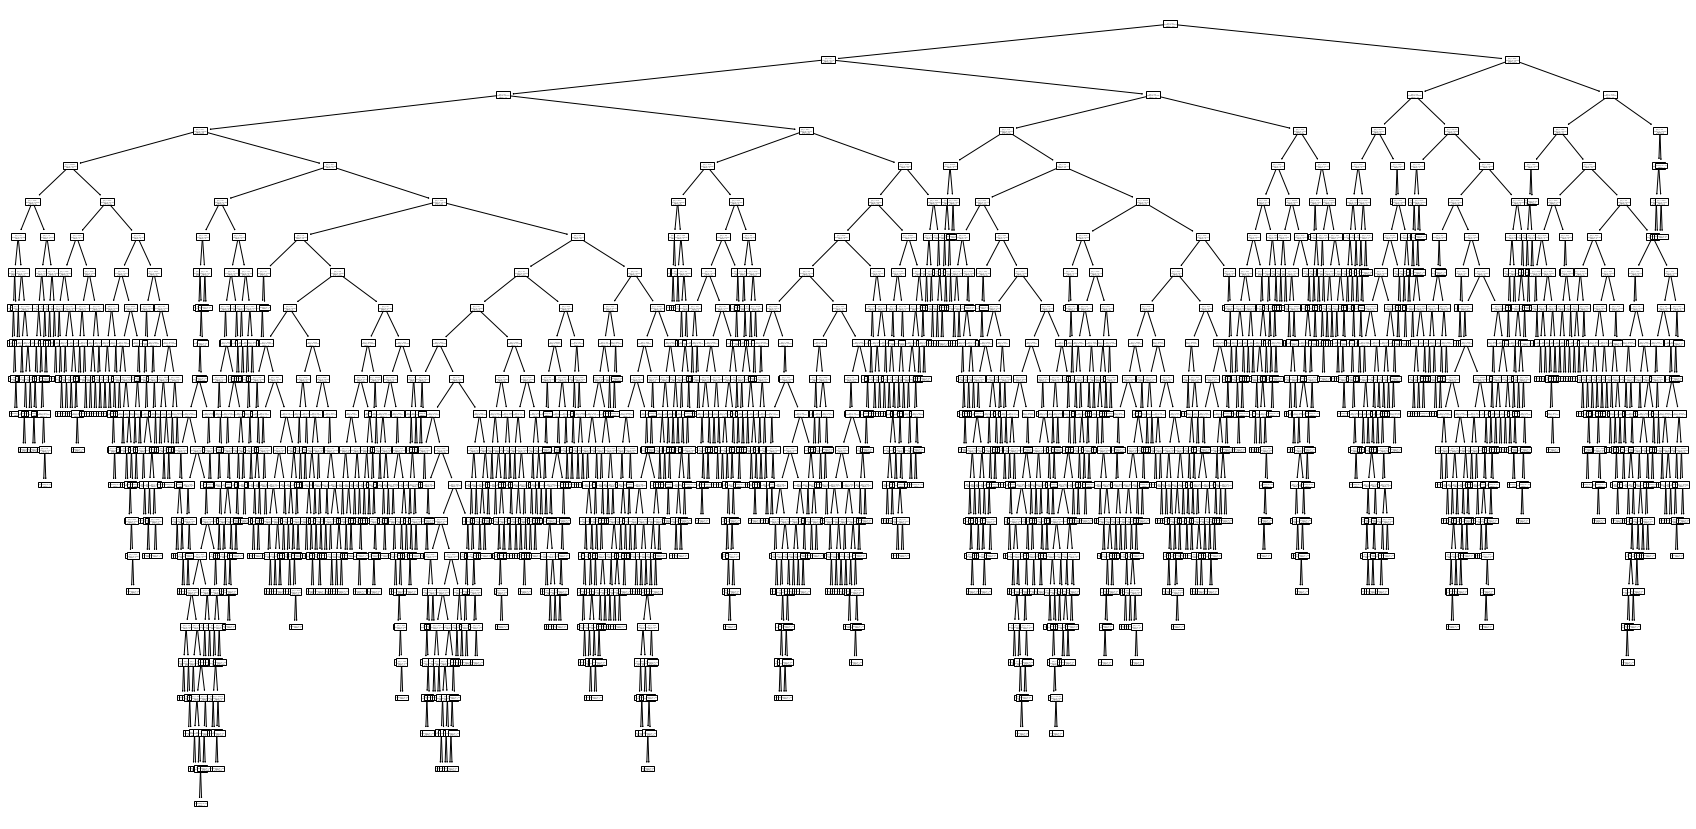

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30, 15))
plot_tree(gender_race_medicare_year_diabetes_obesity_tree_model);

# Random Forest

## Race 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

race_forest_model = RandomForestRegressor(max_features = 1)
X_train = train[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic']]
X_test = test[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic']]
y_train = train['DataValue'] 
y_test = test['DataValue']

race_forest_model.fit(X_train,y_train) 
train_pred = race_forest_model.predict(X_train)
test_pred = race_forest_model.predict(X_test)

train["race_forest_pred"] = train_pred
test["race_forest_pred"] = test_pred

In [ ]:
train_rmse = np.mean((train["race_forest_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["race_forest_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse)

Training set error for random forest: 50.2078110225084
Test set error for random forest:     45.59711152421809


## Medicare 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

medicare_forest_model = RandomForestRegressor(max_features = 1)
X_train = train[['Medicare Expenditure']]
X_test = test[['Medicare Expenditure']]
y_train = train['DataValue']
y_test = test['DataValue']

medicare_forest_model .fit(X_train,y_train) 
train_pred = medicare_forest_model .predict(X_train)
test_pred = medicare_forest_model .predict(X_test)

train["medicare_forest_pred"] = train_pred
test["medicare_forest_pred"] = test_pred

In [ ]:
train_rmse = np.mean((train["medicare_forest_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["medicare_forest_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse) 

Training set error for random forest: 66.47391705702886
Test set error for random forest:     92.46639123567687


## Year

In [ ]:
from sklearn.ensemble import RandomForestRegressor

year_forest_model = RandomForestRegressor(max_features = 1)
X_train = train[['YearStart']]
X_test = test[['YearStart']]
y_train = train['DataValue']
y_test = test['DataValue']

year_forest_model .fit(X_train,y_train) 
train_pred = year_forest_model .predict(X_train)
test_pred = year_forest_model .predict(X_test)

train["year_forest_pred"] = train_pred
test["year_forest_pred"] = test_pred

In [ ]:
train_rmse = np.mean((train["year_forest_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["year_forest_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse)

Training set error for random forest: 74.98489100556907
Test set error for random forest:     76.08618086999356


## Gender

In [ ]:
from sklearn.ensemble import RandomForestRegressor

gender_forest_model = RandomForestRegressor(max_features = 1)
X_train = train[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Male Sex %']]
X_test = test[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Male Sex %']]
y_train = train['DataValue'] 
y_test = test['DataValue']

gender_forest_model.fit(X_train,y_train) 
train_pred = gender_forest_model.predict(X_train)
test_pred = gender_forest_model.predict(X_test)

train["gender_forest_pred"] = train_pred
test["gender_forest_pred"] = test_pred

In [ ]:
train_rmse = np.mean((train["gender_forest_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["gender_forest_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse) 

Training set error for random forest: 26.446402634173957
Test set error for random forest:     46.42552931049815


## Diabetes 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

diabetes_forest_model = RandomForestRegressor(max_features = 1)
X_train = train[['Diabetes Rate']]
X_test = test[['Diabetes Rate']]
y_train = train['DataValue'] 
y_test = test['DataValue']

diabetes_forest_model.fit(X_train,y_train) 
train_pred = diabetes_forest_model.predict(X_train)
test_pred = diabetes_forest_model.predict(X_test)

train["diabetes_forest_pred"] = train_pred
test["diabetes_forest_pred"] = test_pred

In [ ]:
train_rmse = np.mean((train["diabetes_forest_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["diabetes_forest_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse) 

Training set error for random forest: 73.6215834129843
Test set error for random forest:     79.9987785420487


## Obesity 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

obesity_forest_model = RandomForestRegressor(max_features = 1)
X_train = train[['Obesity Rate']]
X_test = test[['Obesity Rate']]
y_train = train['DataValue'] 
y_test = test['DataValue']

obesity_forest_model.fit(X_train,y_train) 
train_pred = obesity_forest_model.predict(X_train)
test_pred = obesity_forest_model.predict(X_test)

train["obesity_forest_pred"] = train_pred
test["obesity_forest_pred"] = test_pred

In [ ]:
train_rmse = np.mean((train["obesity_forest_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["obesity_forest_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse) 

Training set error for random forest: 71.28872187994817
Test set error for random forest:     82.73947304988774


## Gender and Year

In [ ]:
from sklearn.ensemble import RandomForestRegressor

gender_year_forest_model = RandomForestRegressor(max_features = 1)
X_train = train[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Male Sex %', 'YearStart']]
X_test = test[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Male Sex %', 'YearStart']]
y_train = train['DataValue'] 
y_test = test['DataValue']

gender_year_forest_model.fit(X_train,y_train) 
train_pred = gender_year_forest_model.predict(X_train)
test_pred = gender_year_forest_model.predict(X_test)

train["gender_year_forest_pred"] = train_pred
test["gender_year_forest_pred"] = test_pred

In [ ]:
train_rmse = np.mean((train["gender_year_forest_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["gender_year_forest_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse) 

Training set error for random forest: 18.66674670545169
Test set error for random forest:     46.64796785001778


## Gender and Medicare

In [ ]:
from sklearn.ensemble import RandomForestRegressor

gender_medicare_forest_model = RandomForestRegressor(max_features = 1)
X_train = train[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Male Sex %', 'Medicare Expenditure']]
X_test = test[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Male Sex %', 'Medicare Expenditure']]
y_train = train['DataValue'] 
y_test = test['DataValue']

gender_medicare_forest_model.fit(X_train,y_train) 
train_pred = gender_medicare_forest_model.predict(X_train)
test_pred = gender_medicare_forest_model.predict(X_test)

train["gender_medicare_forest_pred"] = train_pred
test["gender_medicare_forest_pred"] = test_pred

In [ ]:
train_rmse = np.mean((train["gender_medicare_forest_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["gender_medicare_forest_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse) 

Training set error for random forest: 15.416148852190808
Test set error for random forest:     37.255614893132154


## Race, Gender, Medicare, and Year

In [ ]:
from sklearn.ensemble import RandomForestRegressor


race_gender_medicare_year_forest_model = RandomForestRegressor(max_features = 1)
X_train = train[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic','Male Sex %', 'Medicare Expenditure', 'YearStart']]
X_test = test[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic','Male Sex %', 'Medicare Expenditure', 'YearStart']]
y_train = train['DataValue'] 
y_test = test['DataValue']

race_gender_medicare_year_forest_model.fit(X_train,y_train) 
train_pred = race_gender_medicare_year_forest_model.predict(X_train)
test_pred = race_gender_medicare_year_forest_model.predict(X_test)

train["race_gender_medicare_year_forest_pred"] = train_pred
test["race_gender_medicare_year_forest_pred"] = test_pred

In [ ]:
train_rmse = np.mean((train["race_gender_medicare_year_forest_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["race_gender_medicare_year_forest_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse) 

Training set error for random forest: 15.385216458961223
Test set error for random forest:     39.01185218778411


## All Features (Race, Gender, Medicare, Year, Diabetes and Obesity)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

feature_forest_model = RandomForestRegressor(max_features = 1)
X_train = train[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Medicare Expenditure', 'YearStart', 'Diabetes Rate', 'Obesity Rate']]
X_test = test[['Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Medicare Expenditure', 'YearStart', 'Diabetes Rate', 'Obesity Rate']]
y_train = train['DataValue'] 
y_test = test['DataValue']

feature_forest_model.fit(X_train,y_train) 
train_pred = feature_forest_model.predict(X_train)
test_pred = feature_forest_model.predict(X_test)

train["feature_forest_pred"] = train_pred
test["feature_forest_pred"] = test_pred

In [ ]:
train_rmse = np.mean((train["feature_forest_pred"] - train["DataValue"]) ** 2) ** 0.5
test_rmse = np.mean((test["feature_forest_pred"] - test["DataValue"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse) 

Training set error for random forest: 15.29225252846773
Test set error for random forest:     36.86855398881475


# Causal Inference

In [ ]:
# Random variables
# Y: the outcome -> Mortality Levels for CVDs
# Z: the decision on whether or not to treat -> PM2.5
# X: confounding variable(s) -> Tobacco Consumption
# W: -> NO2 levels

In [56]:
## OLS Functions 
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = True):
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

def compute_OLS_predictions(input_array, input_params):
    predictions = input_params[0] + input_params[1] * input_array 
    return predictions

In [57]:
cleaned_data.columns

Index(['YearStart', 'LocationDesc', 'DataValue', 'Stratification1',
       'Stratification_American Indian or Alaska Native',
       'Stratification_Asian or Pacific Islander',
       'Stratification_Black, non-Hispanic', 'Stratification_Hispanic',
       'Stratification_White, non-Hispanic', 'Diabetes Rate',
       'Tobacco Consumption Rate', 'Obesity Rate', 'PM2.5 Level - Annual Mean',
       'Male Sex %', 'Medicare Expenditure', 'Wind Speed - Annual Mean',
       'NO2 - Annual Mean'],
      dtype='object')

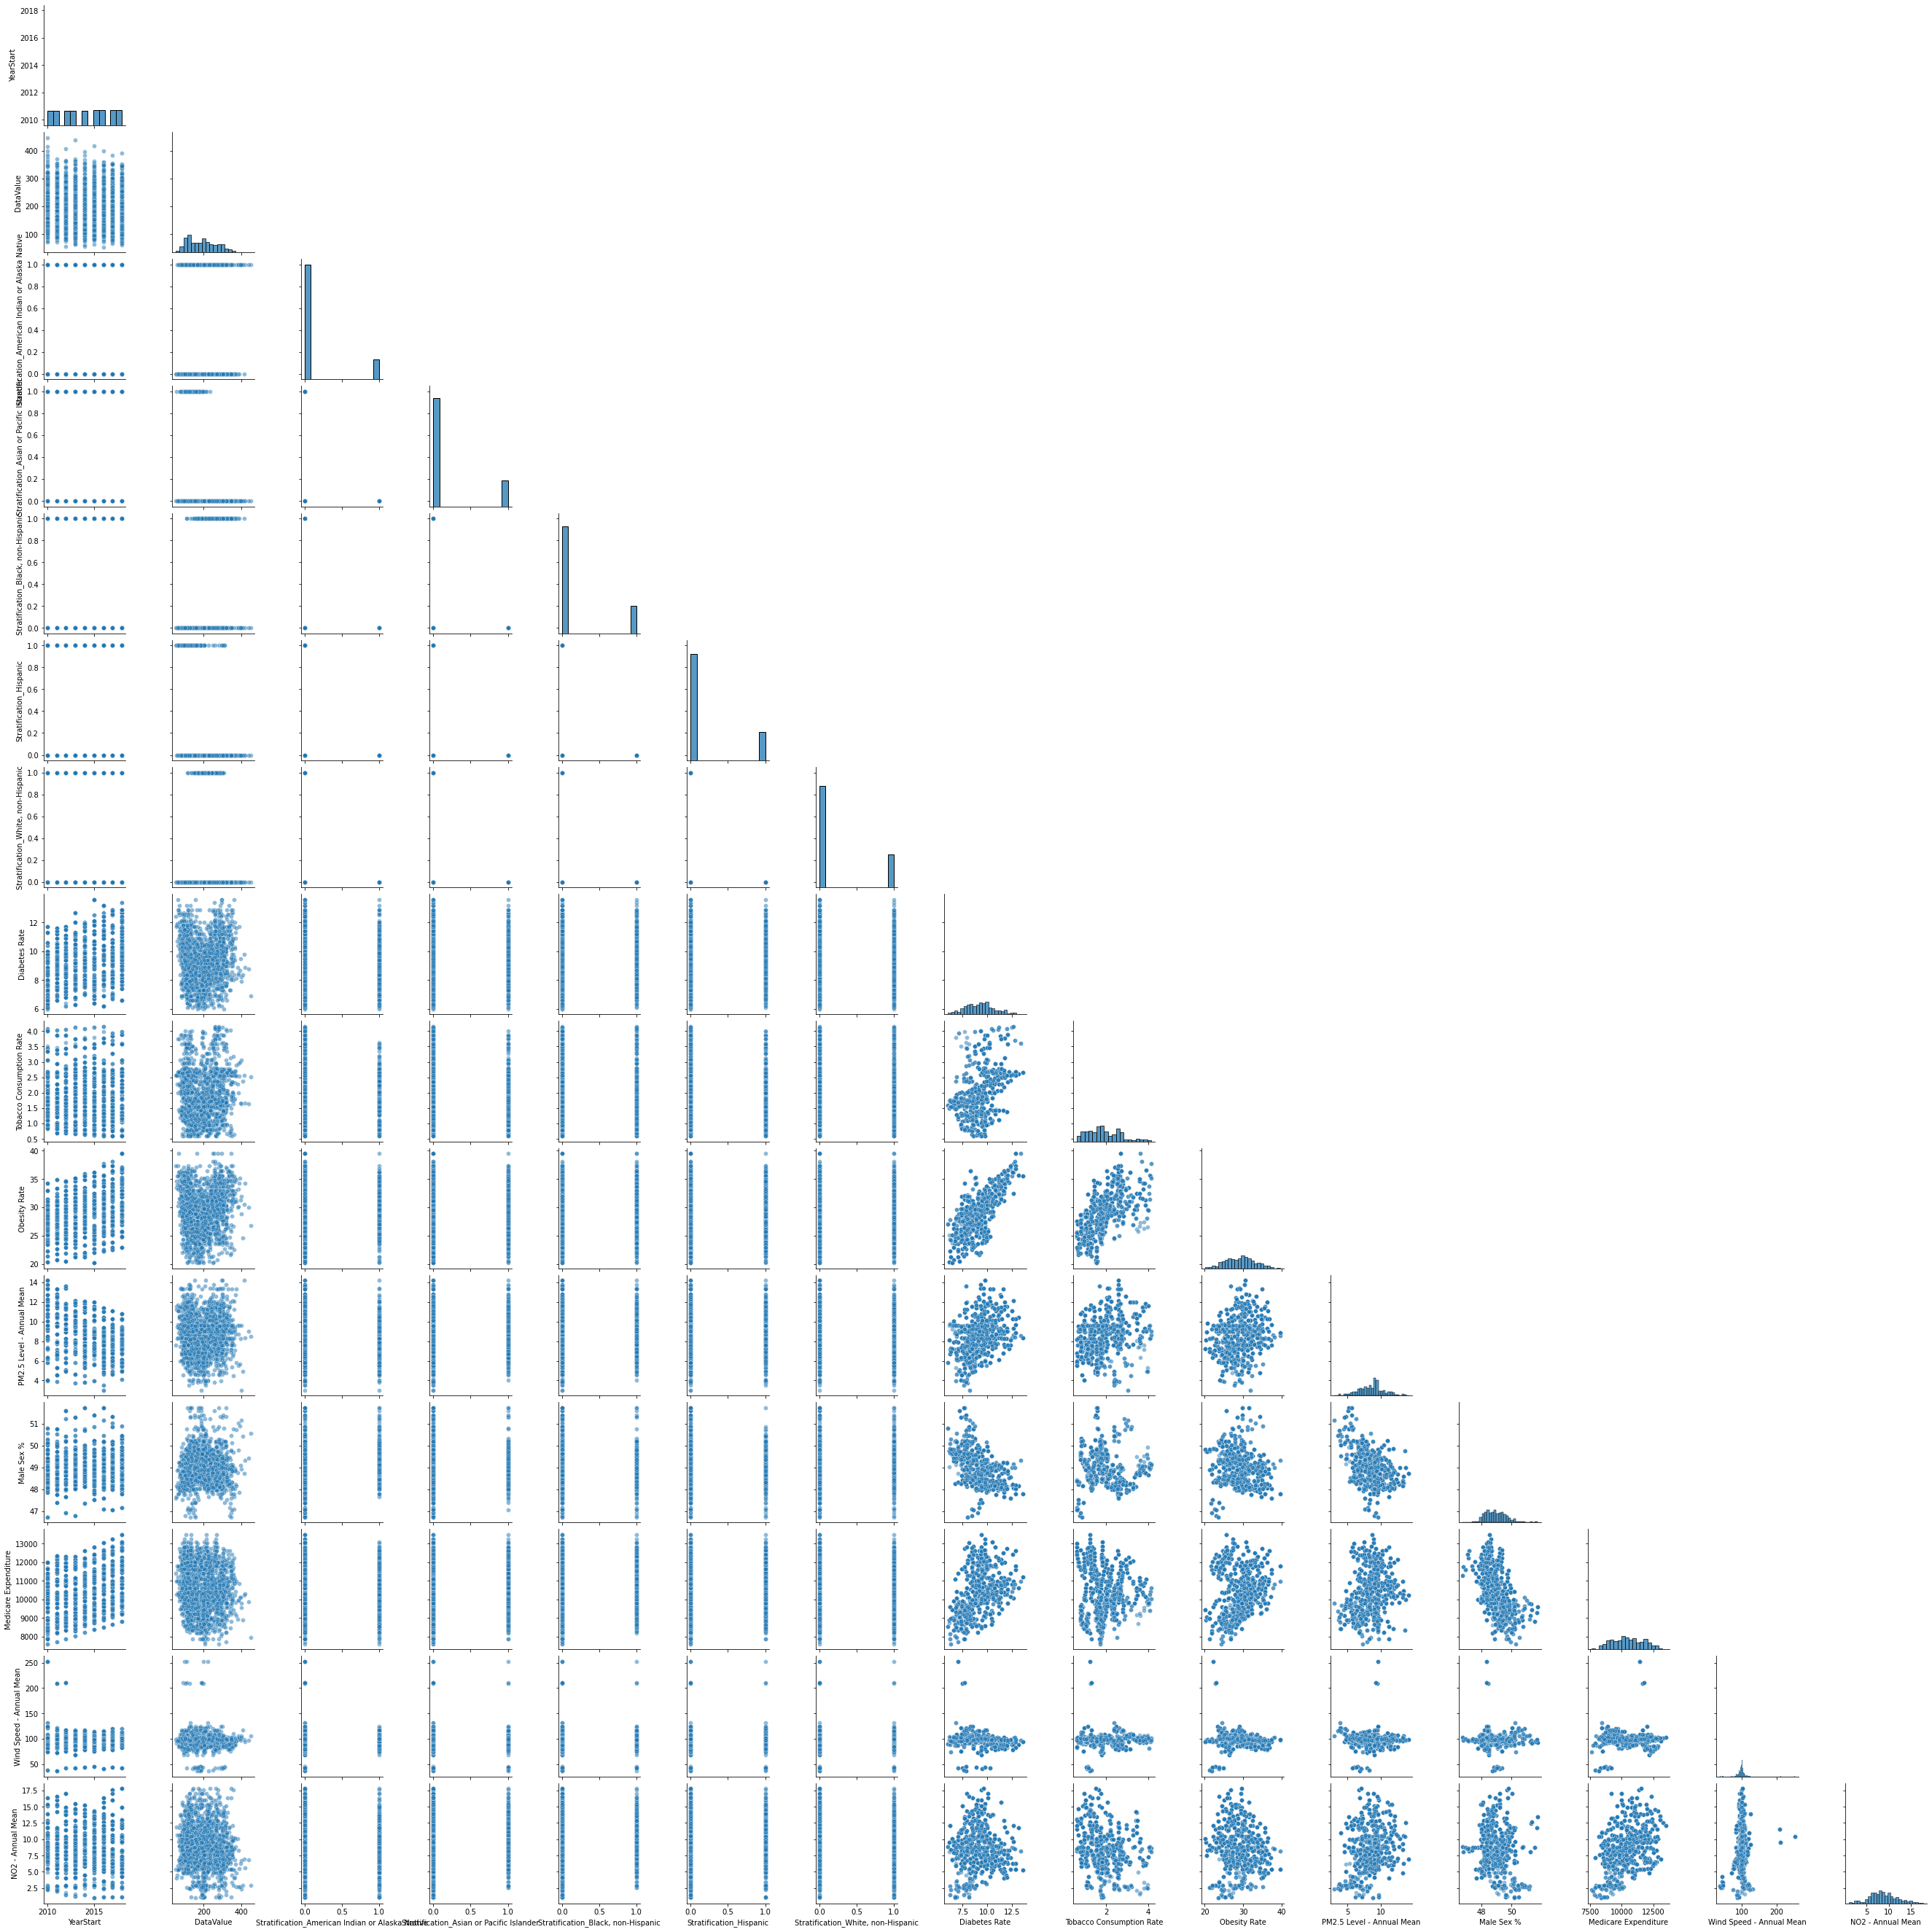

In [ ]:
# Visualize overall association between features 
fig = sns.pairplot(cleaned_data,  plot_kws=dict(marker="o", alpha = 0.5))
for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)
plt.show()

In [ ]:
# Testing Corr of Wind Speed on PM2.5
# x = sns.scatterplot(x='PM2.5 Level - Annual Mean', y = 'Wind Speed - Annual Mean', data = cleaned_data)
# x

# correlation = cleaned_data['Wind Speed - Annual Mean'].corr(cleaned_data['PM2.5 Level - Annual Mean'])
# print(correlation)

In [ ]:
#Testing Corr of NO2 on PM2.5
# x2 = sns.scatterplot(x='PM2.5 Level - Annual Mean', y = 'NO2 - Annual Mean', data = cleaned_data)
# x2

# correlation2 = cleaned_data['NO2 - Annual Mean'].corr(cleaned_data['PM2.5 Level - Annual Mean'])
# print(correlation2)

In [ ]:
# lev = sns.scatterplot(x='DataValue', y = 'PM2.5 Level - Annual Mean', data = cleaned_data)
# lev
# correlation3 = cleaned_data['DataValue'].corr(cleaned_data['PM2.5 Level - Annual Mean'])
# print(correlation3)

In [ ]:
# lev2 = sns.scatterplot(x='DataValue', y = 'NO2 - Annual Mean', data = cleaned_data)
# lev2
# correlation4 = cleaned_data['DataValue'].corr(cleaned_data['NO2 - Annual Mean'])
# print(correlation4)

In [58]:
# We have access to tobacco consumption data X, so can directly estimate
# beta1,beta2, gamma1, gamma2

# Computing OLS estimators for gamma_1 & gamma_2

gammas_model = fit_OLS_model(cleaned_data, 'PM2.5 Level - Annual Mean', ['Tobacco Consumption Rate', 'NO2 - Annual Mean'])
gammas = gammas_model.params

print(gammas_model.summary())
print("The estimated causal effect on PM2.5 Levels of an additional point of Tobacco Consumption {:.2f}".format(gammas[1]))
print("The estimated causal effect on PM2.5 Levels of an additional unit of NO2 is {:.2f}".format(gammas[2]))

                                OLS Regression Results                               
Dep. Variable:     PM2.5 Level - Annual Mean   R-squared:                       0.146
Model:                                   OLS   Adj. R-squared:                  0.145
Method:                        Least Squares   F-statistic:                     160.9
Date:                       Tue, 14 Dec 2021   Prob (F-statistic):           3.24e-65
Time:                               07:55:58   Log-Likelihood:                -3721.0
No. Observations:                       1885   AIC:                             7448.
Df Residuals:                           1882   BIC:                             7465.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [61]:
#Fit OLS parameters to predict Mortality Rate From CVD from the predicted Z_hat (PM2.5).
# beta1_model = fit_OLS_model(cleaned_data, 'DataValue', ['PredictedPM2.5 levels'], intercept = True)

# Compute OLS estimators for beta_1 and beta_2
causal_col = ['PM2.5 Level - Annual Mean', 'Tobacco Consumption Rate']
cleaned_data['DataValue'] = cleaned_data['DataValue'].astype(float)
betas_model = fit_OLS_model(cleaned_data, 'DataValue', causal_col, intercept = True)
print(betas_model.summary()) 

betas = betas_model.params
print("The estimated causal effect on Mortality Rate (CVD) of an additional unit of Tobacco Consumption is {:.2f}".format(betas[2]))
print("The estimated causal effect on Mortality Rate (CVD) of an additional unit of  is {:.2f}".format(betas[1]))

# print("The 2SLS estimate of beta_1 is {:.3f}".format(betas_model.params[1]))


                            OLS Regression Results                            
Dep. Variable:              DataValue   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     7.346
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           0.000664
Time:                        07:56:31   Log-Likelihood:                -10817.
No. Observations:                1885   AIC:                         2.164e+04
Df Residuals:                    1882   BIC:                         2.166e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [63]:
# Predict Z_hat
#Fit OLS parameters to predict PM2.5 Rates from PM2.5 levels

# gamma1_model = fit_OLS_model(cleaned_data, 'PM2.5 Level - Annual Mean', ['NO2 - Annual Mean'], intercept = True)
gamma1_model = fit_OLS_model(cleaned_data, 'PM2.5 Level - Annual Mean', ['NO2 - Annual Mean'], intercept = True)
params = gamma_model.params

print(gamma1_model.summary())
print("The OLS estimate of gamma_1 is {:.3f}".format(gamma1_model.params[1]))

NameError: name 'gamma_model' is not defined

In [ ]:
intercept_OLS = gamma1_model.params[0]
gamma1_OLS = gamma1_model.params[1]
Z_hat = intercept_OLS + gamma_OLS*cleaned_data['NO2 - Annual Mean']

# Add the predictions to the copy of the cleaned_data df
cleaned_data['PredictedPM2.5 levels'] = Z_hat
cleaned_data.head()

In [ ]:
# #Fit OLS parameters to predict Mortality Rate From CVD from the predicted Z_hat (PM2.5).
beta1_model = fit_OLS_model(cleaned_data, 'DataValue', ['PredictedPM2.5 levels'], intercept = True)
print(beta1_model.summary()) 

print("The 2SLS estimate of beta_1 is {:.3f}".format(beta1_model.params[1]))

In [ ]:
# # # Compute predictions for PM2.5 levels 
# # intercept_OLS = gamma1_model.params[0]
# # gamma1_OLS = gamma1_model.params[1]
# # Z_hat = intercept_OLS + gamma1_OLS*cleaned_data['PM2.5 Level - Annual Mean']

# # # Add the predictions to the copy of the cleaned_data df
# # cleaned_data['PredictedPM2.5 levels'] = Z_hat
# # cleaned_data.head()


# # Compute predictions for PM2.5 levels 
# # intercept_OLS = gammas_model.params[0]
# # gamma_OLS = gammas_model.params[1]
# # Z_hat = intercept_OLS + gamma1_OLS*compatible_df['Wind Speed - Annual Mean']
# intercept_OLS = gammas_model.params[0]
# gamma_OLS = gammas_model.params[1]
# Z_hat = intercept_OLS + gamma_OLS*cleaned_data['PM2.5 Level - Annual Mean']

# # Add the predictions to the copy of the cleaned_data df
# cleaned_data['PredictedPM2.5 levels'] = Z_hat
# cleaned_data.head()


YearStart LocationDesc  DataValue                   Stratification1  \
165005       2012       Alaska      126.2         Asian or Pacific Islander   
165075       2011      Arizona      174.7  American Indian or Alaska Native   
165199       2013      Arizona      262.2               Black, non-Hispanic   
165264       2014      Arizona      185.2               White, non-Hispanic   
165314       2010      Alabama      297.3               White, non-Hispanic   

        Stratification_American Indian or Alaska Native  \
165005                                                0   
165075                                                1   
165199                                                0   
165264                                                0   
165314                                                0   

        Stratification_Asian or Pacific Islander  \
165005                                         1   
165075                                         0   
165199                                         0   
165264                                         0   
165314                                         0   

        Stratification_Black, non-Hispanic  Stratification_Hispanic  \
165005                                   0                        0   
165075                                   0                        0   
165199                                   1                        0   
165264                                   0                        0   
165314                                   0                        0   

        Stratification_White, non-Hispanic  Diabetes Rate  \
165005                                   0            7.2   
165075                                   0            9.0   
165199                                   0            9.8   
165264                                   1            9.1   
165314                                   1           11.3   

        Tobacco Consumption Rate  Obesity Rate  PM2.5 Level - Annual Mean  \
165005                  1.589690          25.7                   5.069902   
165075                  1.011420          25.1                   9.755282   
165199                  0.977799          26.8                   8.135052   
165264                  0.965575          28.9                   7.918001   
165314                  2.583559          31.4                  12.705419   

        Male Sex %  Medicare Expenditure  Wind Speed - Annual Mean  \
165005       51.58                8833.0                 93.701692   
165075       49.22                9961.0                 94.463339   
165199       49.22               10056.0                 91.714444   
165264       49.01               10096.0                 92.628181   
165314       48.24                9818.0                 95.154195   

        NO2 - Annual Mean  PredictedPM2.5 levels  
165005           8.750745              10.121483  
165075          16.014585              14.231250  
165199          15.447360              12.810070  
165264          15.197195              12.619685  
165314           8.871013              16.818954

In [ ]:
# #Fit OLS parameters to predict Mortality Rate From CVD from the predicted Z_hat (PM2.5).
# # beta1_model = fit_OLS_model(cleaned_data, 'DataValue', ['PredictedPM2.5 levels'], intercept = True)

# causal_beta_col = ['Tobacco Consumption Rate', 'PredictedPM2.5 levels']
# cleaned_data['DataValue'] = df['DataValue'].astype(float)
# betas_model = fit_OLS_model(cleaned_data, 'DataValue', causal_beta_col, intercept = True)

# print(betas_model.summary()) 
# params = betas_model.params
# print("The 2SLS estimate of beta_1 is {:.3f}".format(betas_model.params[1]))

                            OLS Regression Results                            
Dep. Variable:              DataValue   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     7.346
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           0.000664
Time:                        06:44:03   Log-Likelihood:                -10817.
No. Observations:                1885   AIC:                         2.164e+04
Df Residuals:                    1882   BIC:                         2.166e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
# #Fit OLS parameters to predict Mortality Rate From CVD from the predicted Z_hat (PM2.5).
# # beta1_model = fit_OLS_model(cleaned_data, 'DataValue', ['PredictedPM2.5 levels'], intercept = True)

# causal_beta_col = ['PredictedPM2.5 levels']
# cleaned_data['DataValue'] = df['DataValue'].astype(float)
# betas_model = fit_OLS_model(cleaned_data, 'DataValue', causal_beta_col, intercept = True)

# print(betas_model.summary()) 
# params = betas_model.params
# print("The 2SLS estimate of beta_1 is {:.3f}".format(betas_model.params[1]))

In [ ]:
# # TODO: Fit OLS parameters to predict Z from W
# # causal_beta_col = ['Tobacco Consumption Rate', 'PredictedPM2.5 levels']

# gamma1_model = fit_OLS_model(cleaned_data, 'DataValue', ['NO2 - Annual Mean'], intercept = True)
# print(gamma1_model.summary())

                            OLS Regression Results                            
Dep. Variable:              DataValue   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     12.50
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           0.000417
Time:                        06:49:01   Log-Likelihood:                -10818.
No. Observations:                1885   AIC:                         2.164e+04
Df Residuals:                    1883   BIC:                         2.165e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               210.3830      5.09

In [ ]:
# print("The OLS estimate of gamma_1 is {:.3f}".format(gamma1_model.params[1]))

The OLS estimate of gamma_1 is -1.924


In [ ]:
# # Compute predictions  
# intercept_OLS = gamma1_model.params[0]
# gamma1_OLS = gamma1_model.params[1]
# Z_hat = intercept_OLS + gamma1_OLS * cleaned_data['PM2.5 Level - Annual Mean']

# # Add the predictions  
# cleaned_data['Predicted PM2.5'] = Z_hat
# cleaned_data.head()

YearStart LocationDesc  DataValue                   Stratification1  \
165005       2012       Alaska      126.2         Asian or Pacific Islander   
165075       2011      Arizona      174.7  American Indian or Alaska Native   
165199       2013      Arizona      262.2               Black, non-Hispanic   
165264       2014      Arizona      185.2               White, non-Hispanic   
165314       2010      Alabama      297.3               White, non-Hispanic   

        Stratification_American Indian or Alaska Native  \
165005                                                0   
165075                                                1   
165199                                                0   
165264                                                0   
165314                                                0   

        Stratification_Asian or Pacific Islander  \
165005                                         1   
165075                                         0   
165199                                         0   
165264                                         0   
165314                                         0   

        Stratification_Black, non-Hispanic  Stratification_Hispanic  \
165005                                   0                        0   
165075                                   0                        0   
165199                                   1                        0   
165264                                   0                        0   
165314                                   0                        0   

        Stratification_White, non-Hispanic  Diabetes Rate  \
165005                                   0            7.2   
165075                                   0            9.0   
165199                                   0            9.8   
165264                                   1            9.1   
165314                                   1           11.3   

        Tobacco Consumption Rate  Obesity Rate  PM2.5 Level - Annual Mean  \
165005                  1.589690          25.7                   5.069902   
165075                  1.011420          25.1                   9.755282   
165199                  0.977799          26.8                   8.135052   
165264                  0.965575          28.9                   7.918001   
165314                  2.583559          31.4                  12.705419   

        Male Sex %  Medicare Expenditure  Wind Speed - Annual Mean  \
165005       51.58                8833.0                 93.701692   
165075       49.22                9961.0                 94.463339   
165199       49.22               10056.0                 91.714444   
165264       49.01               10096.0                 92.628181   
165314       48.24                9818.0                 95.154195   

        NO2 - Annual Mean  PredictedPM2.5 levels  Predicted PM2.5  
165005           8.750745              10.121483       200.630103  
165075          16.014585              14.231250       191.616950  
165199          15.447360              12.810070       194.733748  
165264          15.197195              12.619685       195.151284  
165314           8.871013              16.818954       185.941844

In [ ]:
# # TODO: Fit OLS parameters to predict Y from the predicted Z_hat.
# beta1_model = fit_OLS_model(cleaned_data, 'DataValue', ['Predicted PM2.5'], intercept = True)
# # print(beta1_model.summary())
# print("The 2SLS estimate of beta_1 is {:.3f}, while the true value is {}".format(beta1_model.params[1], 5))

                            OLS Regression Results                            
Dep. Variable:              DataValue   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9737
Date:                Tue, 14 Dec 2021   Prob (F-statistic):              0.324
Time:                        06:53:58   Log-Likelihood:                -10824.
No. Observations:                1885   AIC:                         2.165e+04
Df Residuals:                    1883   BIC:                         2.166e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             285.0903     92.890     

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=197ad9fa-af12-4ab2-ba34-eb0a5b2d628f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>